# CATCH ME IF YOU CAN - a social network analysis

## Introduction
Wagwan

## Group Members:

- **[289791]**: Eliya Allam

- **[283791]**: Mattia Cervelli

- **[286881]**: Davide Pisano
  
- **[287611]**: Giulio Presaghi

- **[283361]**: Marco Tagliavini

## Project Overview:
**[WEEK 1](#week1)** -- Understanding the network we are dealing with

**[WEEK 2](#week2)** -- Insights into local connectivity and overall cohesiveness.

**[WEEK 3](#week3)** -- Dealing with the centralities

**[WEEK 5](#week5)** --  Page Rank implementation and cumulative distribution

**[WEEK 6](#week6)** --  

**[WEEK 7](#week7)** --  

## Tools and Technologies Used:

- **Programming Language**: Python
- **Libraries**: Pandas, NumPy, Matplotlib, NetworkX, JSON, HeapQ, community
- **Platform**: Jupyter Notebook

**LIBRARIES WE ARE GOING TO USE:**

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import heapq
import numpy as np
import community
import time
import random
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score

<a id="week1"></a>

**OPENING THE FILE:**


In [2]:
nodes_df = pd.read_csv("dataset/nodes.csv")
edges_df = pd.read_csv("dataset/edges.csv")

The following line takes the *' viz'* column of the *nodes_df* DataFrame and performs two operations:

First, it replaces all single quotes (') with double quotes (") to make the string JSON-compatible.
Then, it parses the modified string as a JSON object, converting it into a *Python dictionary*.

In [3]:
nodes_df[' viz'] = nodes_df[' viz'].apply(lambda row: row.replace("'", '"')).apply(json.loads)

This section initializes an empty undirected graph G. It then iterates over the rows of nodes_df to add nodes to the graph, and over the rows of edges_df to add edges. Each node and edge is added with its associated attributes.

In [4]:
G = nx.Graph()

for index, row in nodes_df.iterrows():
    G.add_node(row['# index'], label=row[' label'], viz=row[' viz'])
for index, row in edges_df.iterrows():
    G.add_edge(row['# source'], row[' target'], label=row[' label'], weight=row[' weight'])

positions = {node: (data['viz']['position']['x'], data['viz']['position']['y']) for node, data in G.nodes(data=True)}
colors = [(data['viz']['color']['r']/255, data['viz']['color']['g']/255, data['viz']['color']['b']/255, data['viz']['color']['a']) for node, data in G.nodes(data=True)]
sizes = [data['viz']['size'] * 100 for node, data in G.nodes(data=True)]

*Graph G* is now ready to be visualized.

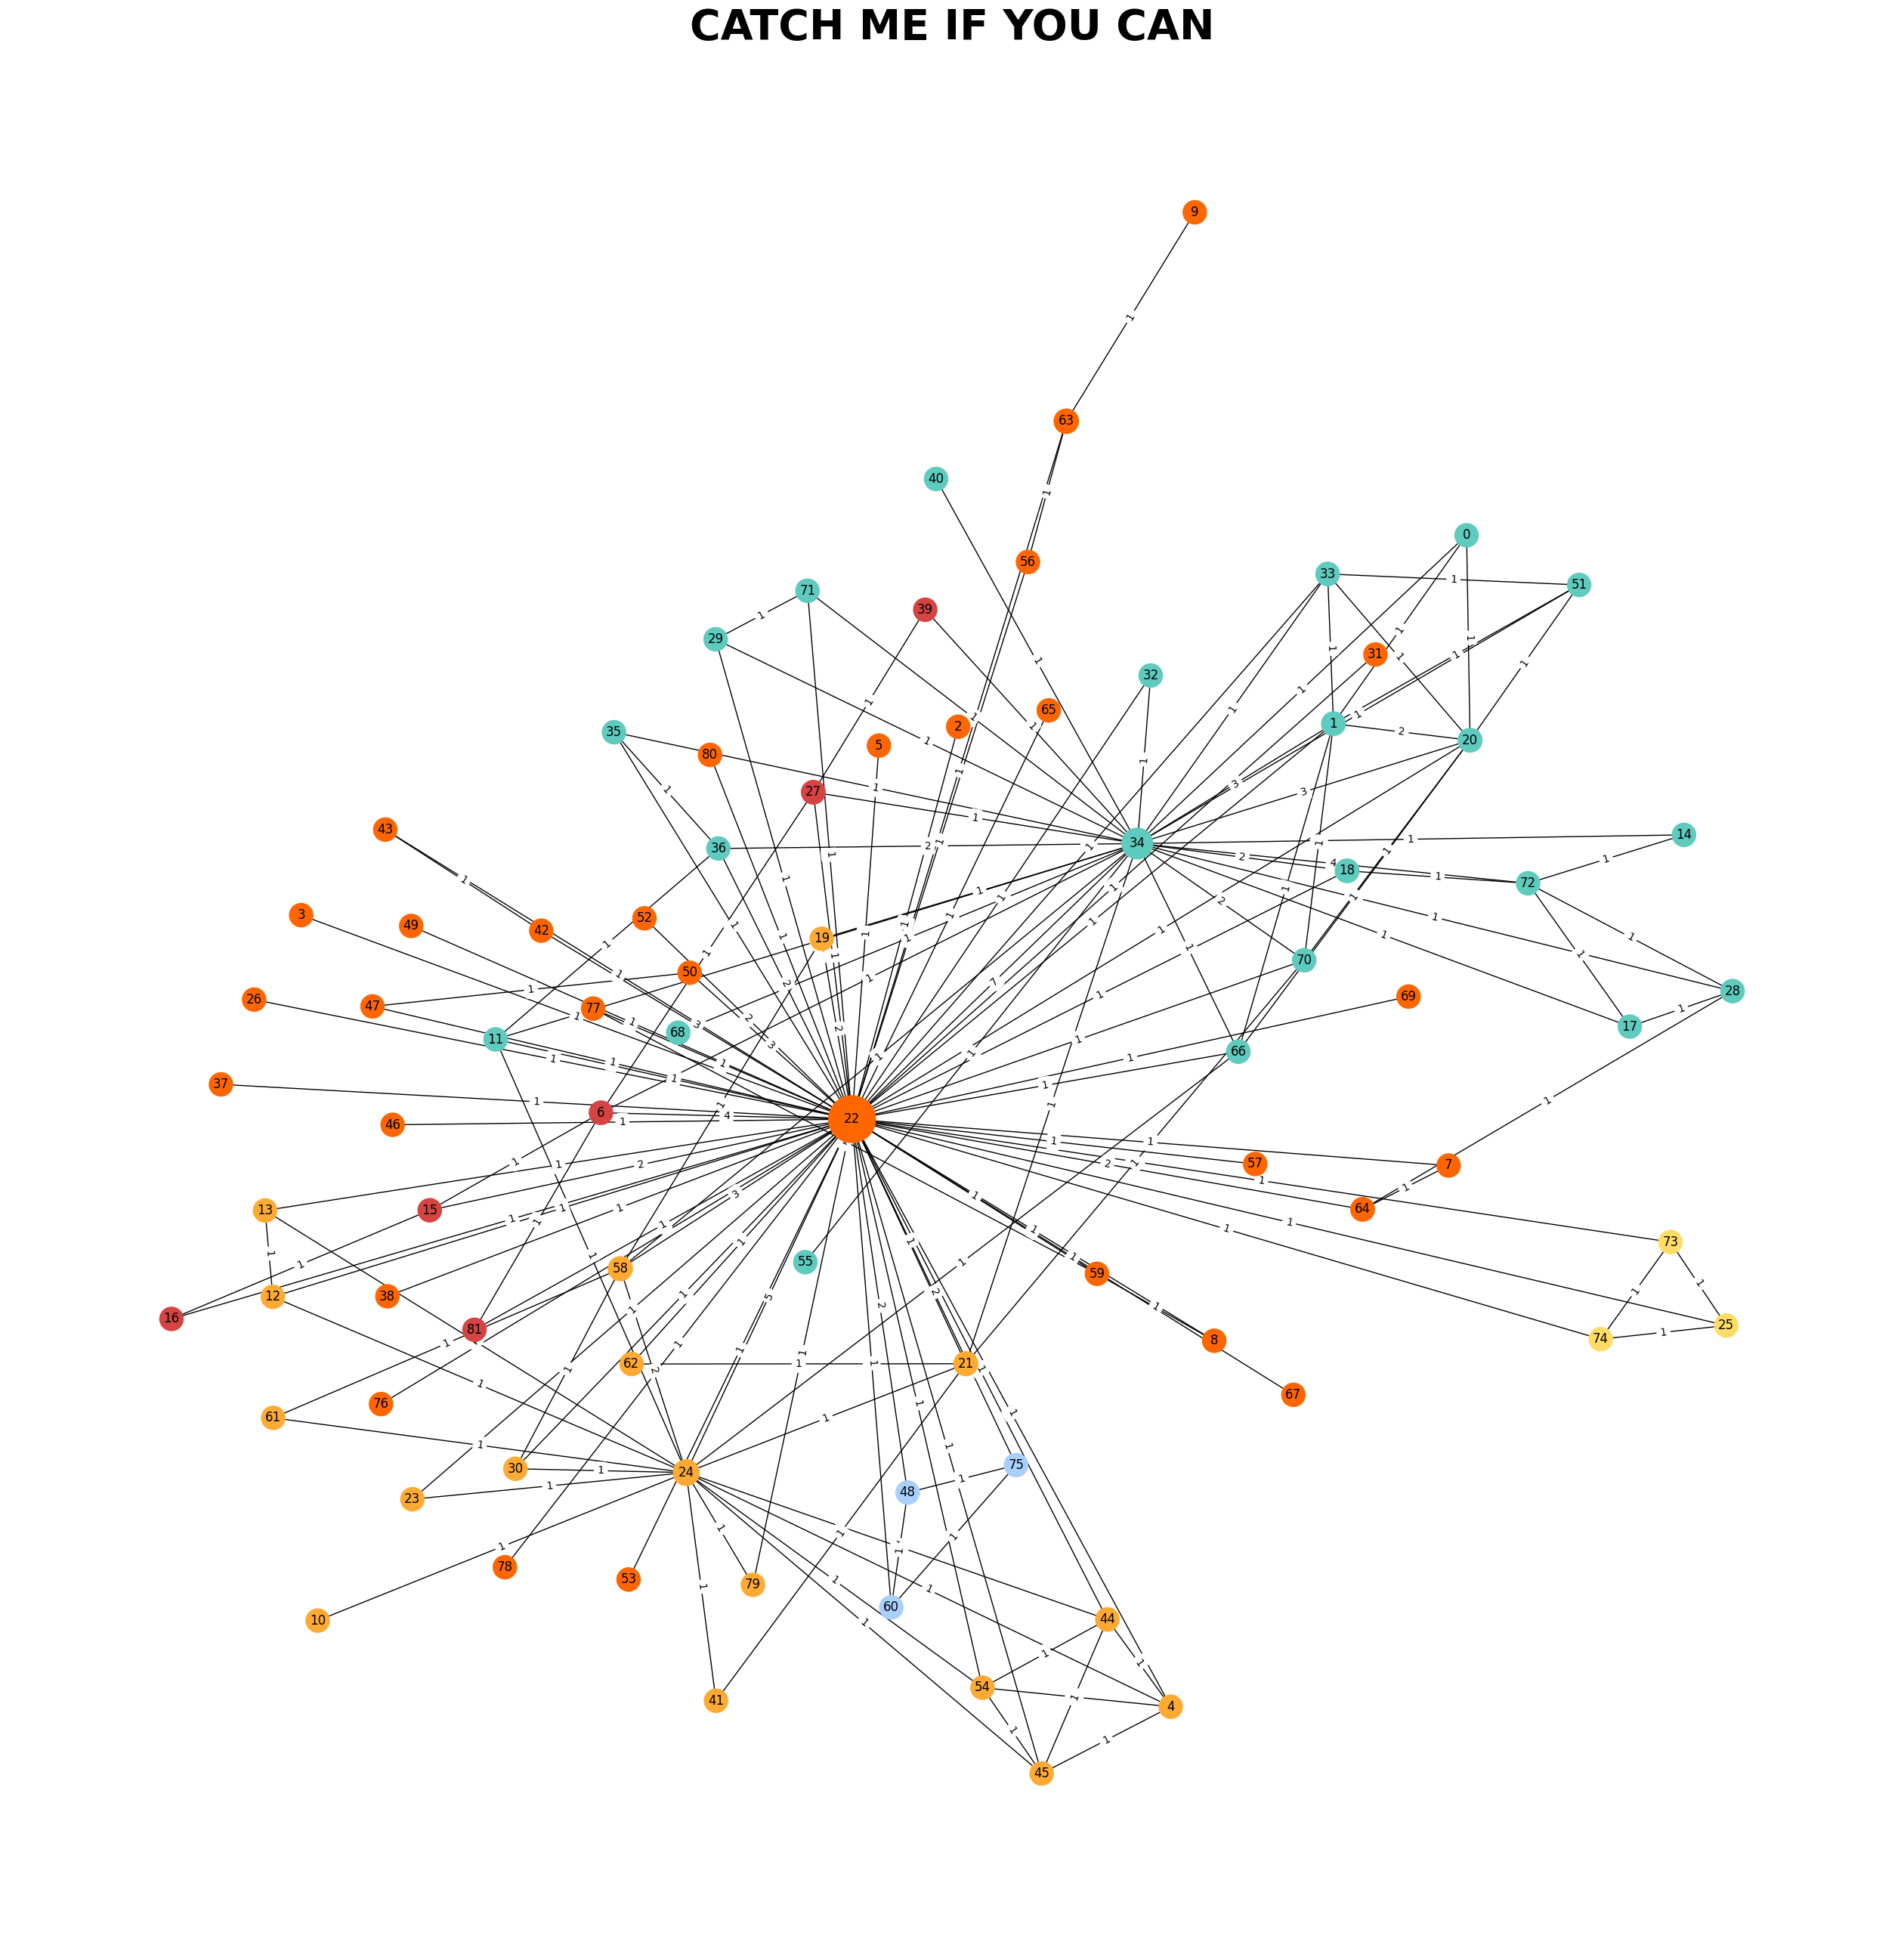

In [5]:

plt.figure(figsize=(25, 25))
nx.draw(G, pos=positions, node_color=colors, node_size=sizes, with_labels=True)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels)
plt.title('CATCH ME IF YOU CAN', size=40, weight='bold')
plt.show()


NUMBER OF NODES, NUMBER OF EDGES, AVERAGE DEGREE AND THE DENSITY

In [6]:
n = G.number_of_nodes()
m = G.number_of_edges()
print("Number of nodes: ", n)
print("Number of edges: ", m)

Number of nodes:  82
Number of edges:  162


the degree k(v)
of a node v is computed by iterating over each edge in the edges_df dataframe
and incrementing the degree count for both the source and target nodes.
Given an edge \((u, v)\) from the dataframe `edges_df`:
$$
k(u) = k(u) + 1
$$
$$
k(v) = k(v) + 1
$$
where \( k(u) \) and \( k(v) \) are the degrees of nodes \( u \) and \( v \) respectively.






The average degree
⟨k⟩ is computed by summing up the degrees of all nodes and dividing by the total number of nodes.
$$
\langle k \rangle = \frac{\sum_{v \in V} k(v)}{N}
$$
where \( N \) is the total number of nodes in the graph and \( k(v) \) is the degree of node \( v \).


In [7]:
def compute_degrees(edges_df):
    degrees = {}

    for index, row in edges_df.iterrows():
        source = row['# source']
        target = row[' target']

        degrees[source] = degrees.get(source, 0) + 1
        degrees[target] = degrees.get(target, 0) + 1

    return degrees

def compute_average_degree(edges_df):
    degrees = compute_degrees(edges_df)
    total_degree = sum(degrees.values())
    N = len(degrees)

    return total_degree / N


In [8]:
print("Average degree: ", compute_average_degree(edges_df))

Average degree:  3.951219512195122


The formula for the density \( D \) of an undirected graph is:

$$
D = \frac{2M}{N(N-1)}
$$

Where:
- \( M \) is the number of edges in the graph.
- \( N \) is the number of nodes in the graph.


In [9]:
def density(G):
    n = len(G.nodes())
    m = len(G.edges())
    if n == 0 or n == 1:
        return 0.0
    density = (2 * m) / (n * (n - 1))

    return density
print('Density:', density(G))

Density: 0.04878048780487805


<a id='week2'></a>
**WEEK 2 ANALYSIS** -

While considering the largest component of your network. Depending on what you prefer/seems
more relevant in your graph

**- Compute Average clustering and Transitivity number**

**- Implement a function computing the transitivity using basic function of networkx**

DIJKSTRA’S ALGORITHM

In [10]:
def dijkstra_generic(G, start_node, use_weights=True):
    distances = {node: float('inf') for node in G.nodes()}
    distances[start_node] = 0
    pq = [(0, start_node)]
    while pq:
        current_distance, current_node = heapq.heappop(pq)
        for neighbor, edge_attr in G[current_node].items():
            weight = edge_attr['weight'] if use_weights else 1
            new_distance = current_distance + 1/weight
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                heapq.heappush(pq, (new_distance, neighbor))
    return distances
all_unweighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=False)
                                        for node in G.nodes()}
all_weighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=True)
                                      for node in G.nodes()}


Given the nature of the data (same-scene appearances), the average clustering and transitivity seemed be more relevant to us. These metrics would provide a clearer picture of character interactions and how characters are grouped or clustered in the narrative. It would highlight which characters frequently share scenes and are thus likely central to the movie's main plot or subplots.

We, thus, implemented a first function which retrieves the number of triangles in the graph. This is done by iterating over each node in the graph and counting the number of triangles that the node is part of. The number of triangles is then divided by the number of connected triples in the graph to get the transitivity.

**TRIANGLES** -
$$
\{u, v, w\} \text{ forms a triangle if } (u, v), (v, w), \text{ and } (u, w) \text{ are edges in the graph}
$$

**TRANSITIVITY** -
$$
T = \frac{3 \times \text{triangles\_count}}{\text{wedges}}
$$
Where:
'TRIANGLES COUNT' is the number of unique triangles in the graph and
'WEDGES' is the sum of the number of pairs of neighbors for each node in the graph.


In [11]:
def count_triangles(G, node):
    neighbors = set(G.neighbors(node))
    count = 0
    for u in neighbors:
        for v in neighbors:
            if u != v and G.has_edge(u, v):
                count += 1
    return count // 2  # Each triangle is counted twice for each node

def total_triangles(G):
    triangle_count = 0
    for node in G.nodes():
        triangle_count += count_triangles(G, node)
    return triangle_count // 3  # Each triangle is counted three times


triangles_in_graph = total_triangles(G)
def custom_transitivity_from_triangles(G, triangle_count):
    triples = sum(len(list(nx.ego_graph(G, v))) * (len(list(nx.ego_graph(G, v))) - 1) for v in G) / 2
    if triples == 0:
        return 0
    return (3 * triangle_count) / triples
custom_trans_from_triangles = custom_transitivity_from_triangles(G, triangles_in_graph)


We then implemented a second function which computes the average clustering coefficient of the graph. This is done by iterating over each node in the graph and computing the clustering coefficient of the node.

**Clustering Coefficient for a Node**:
For a given node \( v \) with degree \( k \):
$$
C(v) = \frac{2T(v)}{k(k-1)}
$$
Where \( T(v) \) is the number of triangles involving node \( v \).

The clustering coefficient of the node is then added to the total clustering coefficient of the graph. The total clustering coefficient is then divided by the number of nodes in the graph to get the average clustering coefficient.

**Average Clustering Coefficient**:
For the entire graph \( G \):
$$
C = \frac{1}{n} \sum_{v \in V} C(v)
$$
Where \( n \) is the number of nodes in \( G \) and \( V \) is the set of nodes.

In [12]:
def avg_clustering(G):
    total_clustering_coeff = 0
    for node in G.nodes():
        k = len(list(G.neighbors(node)))
        if k < 2:
            continue
        
        T = count_triangles(G, node)
        local_clustering_coeff = (2 * T) / (k * (k - 1))
        total_clustering_coeff += local_clustering_coeff
    
    return total_clustering_coeff / len(G.nodes())

avg_clustering_custom = avg_clustering(G)
avg_clustering_custom


0.5990508780501608

<a id='week3'></a>
**WEEK 3 ANALYSIS** -

Depending on what seems more relevant in your graph, pick one of the following local notions

- *Decay centrality*
  
- *Betweeness centrality*
  
- *Closeness centrality*
  
- *Clustering*
  
- *Any other notions that you invent*
  
**1) Provide a code computing the given centrality using basic functions of networkx (you are not allowed to use directly nx."what you want").**

**2) Discuss why you picked this measure and who is the most central in your network based on your  choice.**

**3) Provide the cumulative distribution for this centrality and give a graphical representation of your graph(log-log, log or normal representation as you think it is more relevant).**

**CLOSENESS CENTRALITY**
could be a relevant approach in our analysis. It would allow us to identify the characters who are most central to the narrative. These characters would be the ones who are most likely to be involved in the main plot or subplots of the movie.

Therefore, given the following formula for the **Closeness Centrality**:

$$ C(u) = \frac{n - 1}{\sum_{v \neq u} d(v, u)} $$

This is the corresponding implementation:

In [34]:
def custom_closeness_centrality(G, all_unweighted_shortest_path_lengths):
    closeness_centrality = {}
    N = len(G.nodes)

    for u in G.nodes:
        sp_length = all_unweighted_shortest_path_lengths[u]
        n = len(sp_length)
        closeness_centrality[u] = (n - 1) / (N - 1) if n != 1 else 0.0
        closeness_centrality[u] /= sum(sp_length.values()) if n != 1 else 1.0

    return closeness_centrality
all_unweighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=False) for node in G.nodes()}

closeness_centrality_custom = custom_closeness_centrality(G, all_unweighted_shortest_path_lengths)
most_central_character = max(closeness_centrality_custom, key=closeness_centrality_custom.get)

print('Most central character:', most_central_character)
print('Closeness centrality:', closeness_centrality_custom[most_central_character])


Most central character: 22
Closeness centrality: 0.010526315789473684


It results that our protagonist (node 22) has relatively low closeness centrality, shich suggest that the character is not closely connected to many other characters in the movie, indicating a potential narrative focus on isolated or introspective journeys, distinct subplots or a fragmented narrative.

**DISPLAYING THE NORMALIZED CLOSENESS CENTRALITY FOR EACH NODE**

**Normalized_closeness_values =** 

**Values** = this is the original value from our data, the closeness centrality of a node

**Min_value** = this is the smallest value in our data. subtracting this from value shifts our data so that the smallest value now is zero

**Max_value** = this is the largest value in our data. dividing by (max_value - min_value) scales our data so that the largest value is now one 

**the result is that all our data are now on a scale form 1 to zero**

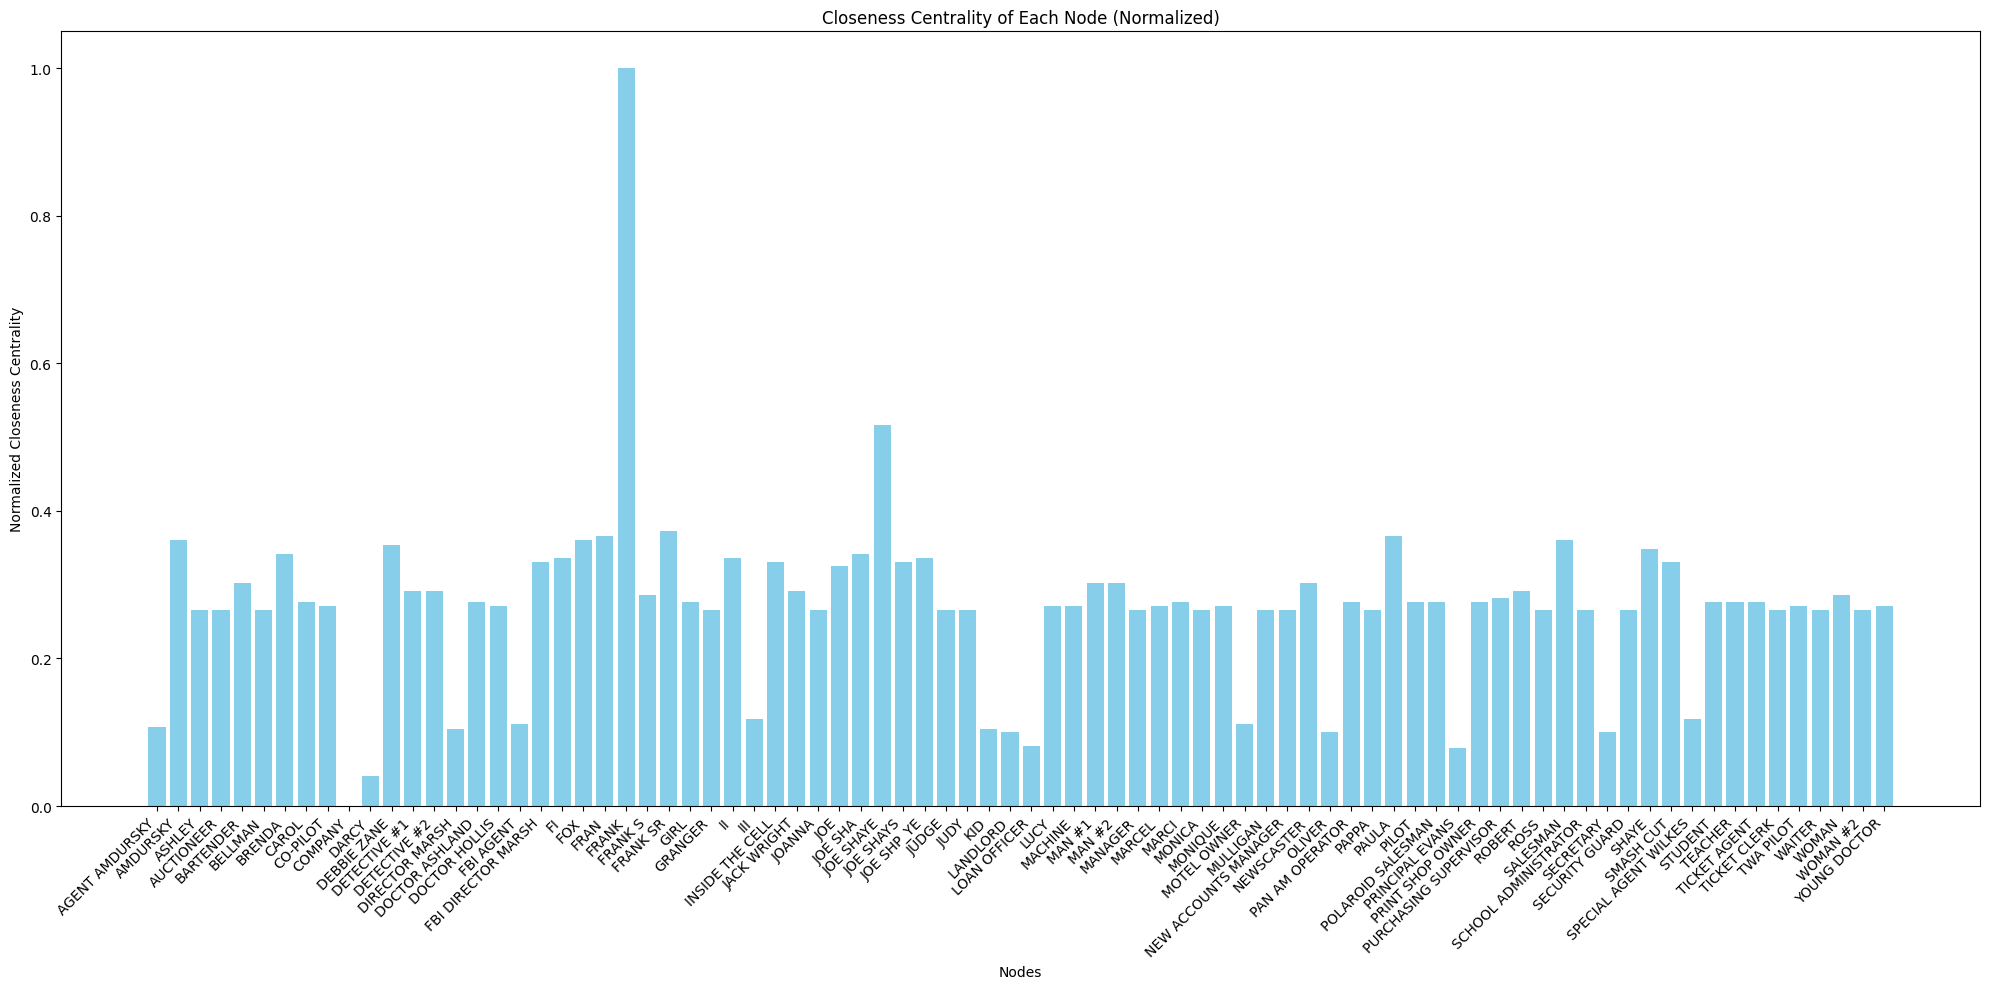

In [60]:
node_names = nodes_df[' label'].tolist()
closeness_values = list(closeness_centrality_custom.values())
min_value = min(closeness_values)
max_value = max(closeness_values)
normalized_closeness_values = [(value - min_value) / (max_value - min_value) for value in closeness_values]

plt.figure(figsize=(20,10))
plt.bar(node_names, normalized_closeness_values, color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Normalized Closeness Centrality')
plt.title('Closeness Centrality of Each Node (Normalized)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**DISPLAYING THE CUMULATIVE DISTRIBUTION FOR THE CLOSENESS CENTRALITY**

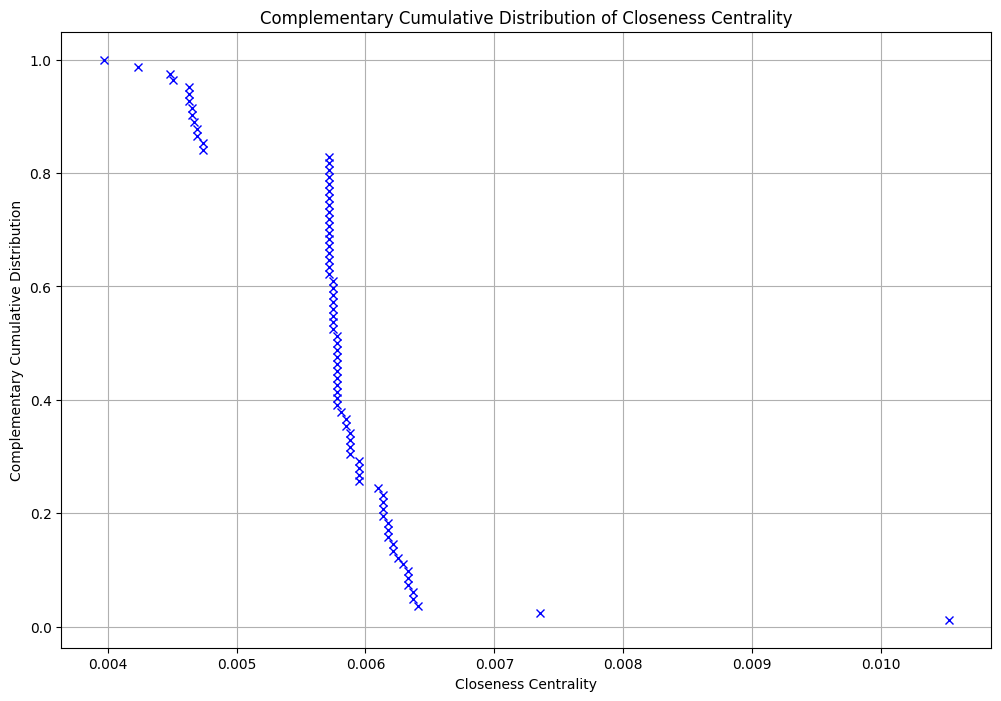

In [61]:
closeness_values = sorted(list(closeness_centrality_custom.values()))

ccdf_y = np.arange(1, len(closeness_values) + 1)[::-1] / len(closeness_values)
ccdf_x = closeness_values

plt.figure(figsize=(12,8))
plt.plot(ccdf_x, ccdf_y, "x", color='blue')
plt.xlabel('Closeness Centrality')
plt.ylabel('Complementary Cumulative Distribution')
plt.title('Complementary Cumulative Distribution of Closeness Centrality')
plt.grid(True, which="both")
plt.show()


<a id='week5'></a>
**WEEK 5 ANALYSIS** -
  

*1) Write a function to compute the PageRank of the nodes in a graph (you are not allowed to
use built-in functions from NetworkX).*


*2) Run it on your graph using ff = 0.15, save the total number of iterations, and check that
your function returns the same results (in terms of the scores) as the built-in function from
NetworkX.*


*3) Identify the node with the highest PageRank, compare it with the one you got from week 3,
and give an interpretation to the possible difference.*


*4) Provide the cumulative distribution, compare it with the one you got from week 3, and
comment the results.*


*5) Optional: Re-run the PageRank using ff = 0.5, save the total number of iterations, compare
with the results (in terms of both the number of iterations and the cumulative distribution)
obtained for ff = 0.15, and comment.*

# PageRank Computation

The `compute_pagerank` function calculates the PageRank of nodes in a graph `G`. The PageRank algorithm measures the importance of each node within the graph, based on the principle that connections to high-scoring nodes contribute more to the score of the node in question.

## Parameters:
- `G`: A NetworkX graph.
- `alpha`: The damping factor which represents the probability that a user will continue clicking on links (default is 0.15).
- `max_iter`: The maximum number of iterations to perform (default is 100).
- `convergence`: The threshold of change in PageRank values between iterations that is considered sufficient for convergence (default is 1e-6).

## Algorithm Steps:
1. Initialize the PageRank of every node to be equal (1/N where N is the number of nodes).
2. Calculate the number of out-links for each node.
3. Iteratively update the PageRank of each node based on the PageRank of its neighbors and the number of out-links those neighbors have.
4. If the change in PageRank for all nodes is below the convergence threshold, return the PageRank values and the number of iterations performed.
5. If the maximum number of iterations is reached, return the current PageRank values and the max_iter.

## PageRank Formula:
The PageRank of a node `i` is calculated as follows:

$$
PR(i) = \frac{\alpha}{N} + (1 - \alpha) \sum_{j \in M(i)} \frac{PR(j)}{L(j)}
$$

Where:
- `PR(i)`: PageRank of node `i`.
- `N`: Total number of nodes.
- `alpha`: Damping factor.
- `M(i)`: Set of nodes that link to node `i`.
- `L(j)`: Number of out-links for node `j`.
- The sum is over the set `M(i)`, which contains all nodes that link to node `i`.

## Return Values:
- The function returns a tuple (`rank`, `iterations`), where `rank` is a dictionary of nodes with their PageRank scores, and `iterations` is the number of iterations performed to reach convergence or the maximum iterations allowed.


In [16]:
def compute_pagerank(G, alpha=0.15, max_iter=100, convergence=1e-6):
    N = len(G)
    if N == 0:
        return {}
    rank = {node: 1/N for node in G}
    
    out_links = {node: len(list(G.neighbors(node))) for node in G}
    
    for iteration in range(max_iter):
        new_rank = {}
        for node in G:
            rank_sum = sum(rank[neighbor] / out_links[neighbor] for neighbor in G.neighbors(node))
            new_rank[node] = (alpha/N) + (1-alpha) * rank_sum
        if all(abs(new_rank[node] - rank[node]) <= convergence for node in G):
            return new_rank, iteration + 1
        
        rank = new_rank
    
    return rank, max_iter

**COMPARISON BETWEEN OUR PAGERANK AND THE NETWORKX ONE**

In [17]:
# Run the custom PageRank function with ff as 1 - alpha
pagerank, iterations = compute_pagerank(G, alpha=0.15)

# Run the built-in NetworkX PageRank function with alpha set to 0.85 (which is 1 - ff)
pagerank_nx = nx.pagerank(G, alpha=0.85)

print("Custom PageRank iterations:", iterations)
for node in sorted(pagerank):
    print(f"Node {node}: Custom PageRank = {pagerank[node]}, NetworkX PageRank = {pagerank_nx[node]}")


Custom PageRank iterations: 25
Node 0: Custom PageRank = 0.008367118354437642, NetworkX PageRank = 0.007013198294580523
Node 1: Custom PageRank = 0.02016086129753627, NetworkX PageRank = 0.022029554945055575
Node 2: Custom PageRank = 0.004390621342402146, NetworkX PageRank = 0.0038687075875165214
Node 3: Custom PageRank = 0.004390621342402146, NetworkX PageRank = 0.0038687075875165214
Node 4: Custom PageRank = 0.013613492289128457, NetworkX PageRank = 0.011796145442644228
Node 5: Custom PageRank = 0.004390621342402146, NetworkX PageRank = 0.0038687075875165214
Node 6: Custom PageRank = 0.014980808766163818, NetworkX PageRank = 0.01861803751313391
Node 7: Custom PageRank = 0.0072258950860248005, NetworkX PageRank = 0.0061226122011679394
Node 8: Custom PageRank = 0.007422137556727871, NetworkX PageRank = 0.006539989987060084
Node 9: Custom PageRank = 0.0052943046711472624, NetworkX PageRank = 0.004965196916165868
Node 10: Custom PageRank = 0.004109239059989309, NetworkX PageRank = 0.0037

In [18]:
highest_PR = max(pagerank, key=pagerank.get)
print('Highest PageRank:', highest_PR)
print("Frank's PageRank:", pagerank[highest_PR])

Highest PageRank: 22
Frank's PageRank: 0.20189566465520883


## Interpretation of Closeness Centrality and PageRank Results

The analysis of the network has yielded some interesting insights into the structure and the importance of nodes within it. Specifically, we have identified that the most central character in the network is ***Frank***, according to both closeness centrality and PageRank measures. However, the magnitude of the centrality measures differs significantly, which warrants a careful interpretation.

### Closeness Centrality:

- **Frank's Closeness Centrality**: `0.013585198602665282`
- Closeness centrality measures how close a node is to all other nodes in the network. A higher closeness centrality indicates that a node can spread information more efficiently through the network since, on average, it is 'closer' to all other nodes.
- The closeness centrality of Frank (node 22) suggests that Frank is relatively central in the network, implying that he can quickly interact with other nodes within the network. This might indicate that Frank is well-positioned to influence the network or to access information from various parts of the network efficiently.

### PageRank:

- **Frank's PageRank**: `0.20189566465520883`
- PageRank, on the other hand, measures the importance of nodes based on the structure of incoming links. It is not just about how many connections a node has, but also how significant those connections are. A node linked by other highly ranked nodes will have a high PageRank.
- Frank's high PageRank indicates that he is not only well-connected but also that the nodes connecting to him are themselves important or well-connected within the network. This suggests that Frank could be a key figure or hub in the network, wielding considerable influence or authority.

### Comparative Analysis:

- The fact that node 22 is identified as significant by both measures reinforces the idea that this node is pivotal within the network. However, the two measures capture different aspects of centrality:
  - **Closeness Centrality** is about reachability and efficiency in the network. It reflects how easily a node can reach all other nodes directly or indirectly. A higher closeness centrality score for Frank means he is well-placed to quickly interact with others in the network, which can be crucial for rapid communication or dissemination of information.
  - **PageRank** is about influence and authority. It takes into account not only the number of connections but also the quality of these connections. Frank's high PageRank suggests that he is not just connected but connected to nodes that are themselves important, which can be interpreted as Frank having a form of indirect influence over the network through these significant connections.

- In this network, while Frank's closeness centrality is relatively modest, his PageRank is quite high. This could indicate that while Frank may not be the fastest at spreading information (as closeness centrality suggests), he holds a position of significant influence (as indicated by PageRank).

### Conclusion:

In summary, node 22, or Frank, appears to be a key player in the network, with a strong ability to influence through his connections, as indicated by his high PageRank. However, his reachability to all other nodes is not the most efficient, as shown by his lower closeness centrality score.



## Page Rank Cumulative Distribution ##

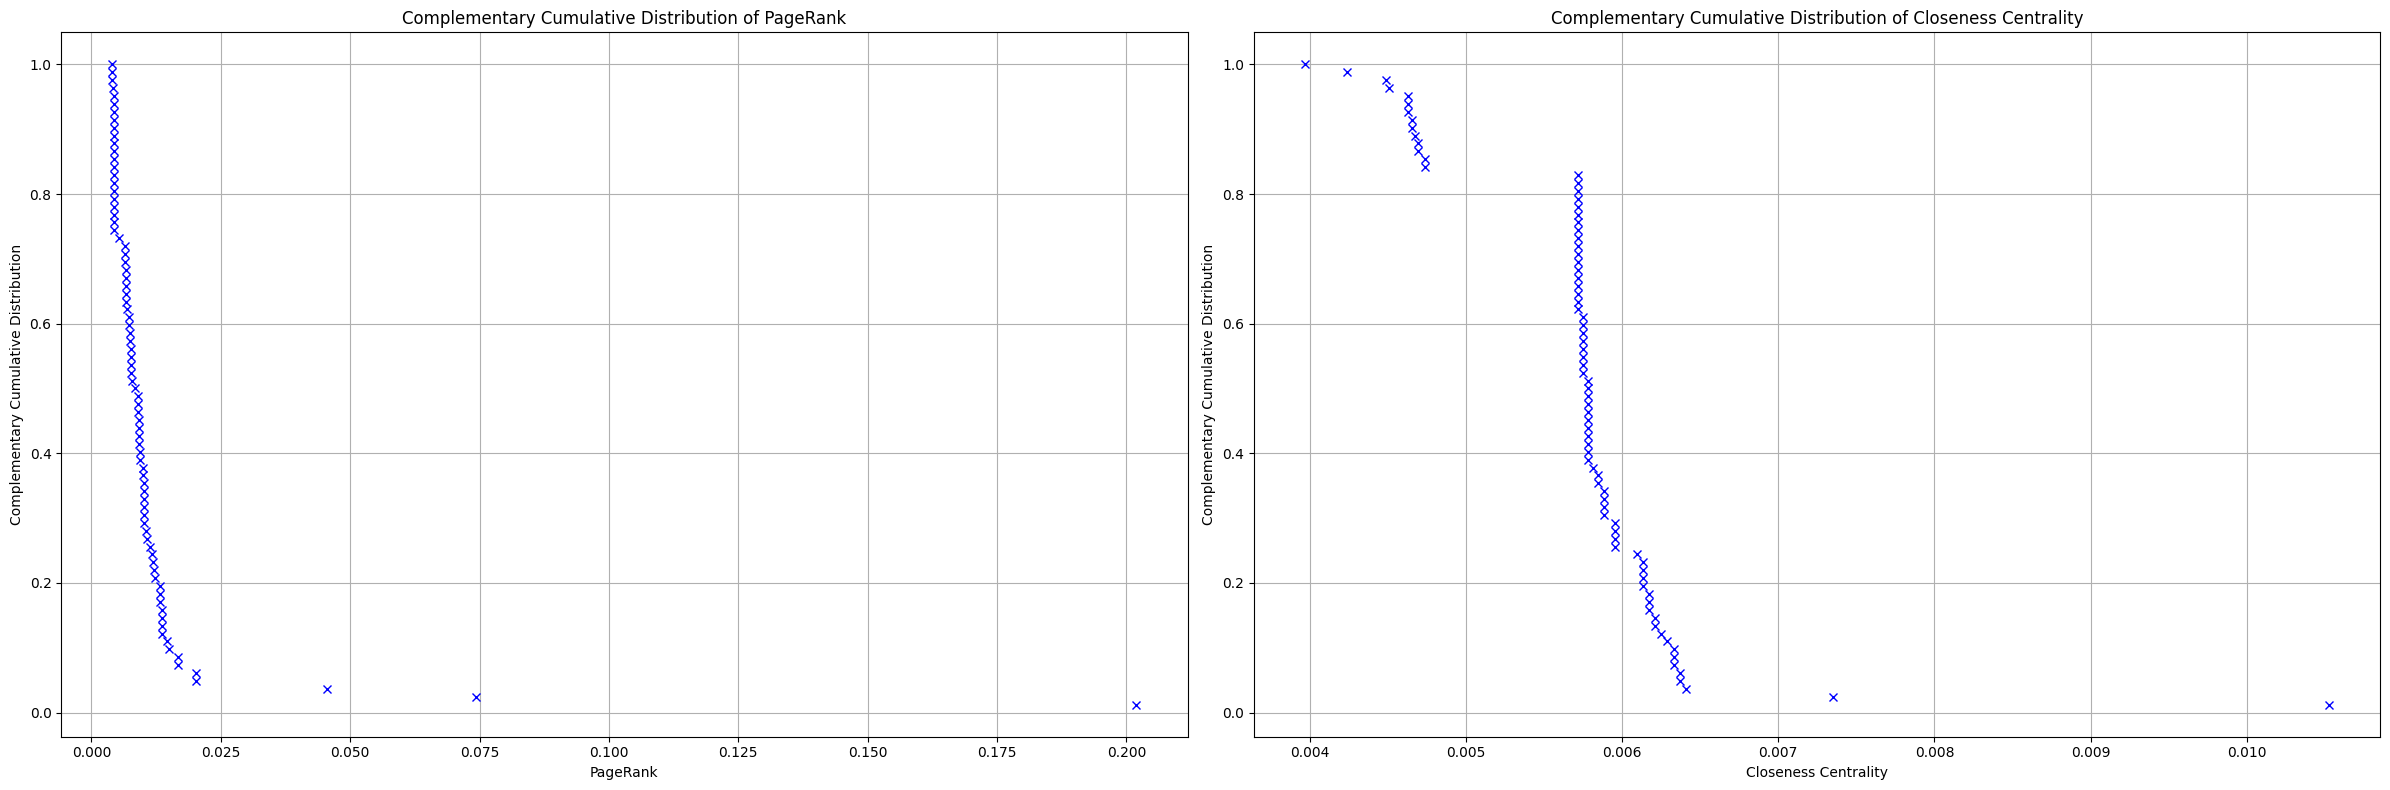

In [19]:
# Calculate the CCDF for PageRank
PR_values = sorted(list(pagerank.values()))
ccdf_y_pr = np.arange(1, len(PR_values) + 1)[::-1] / len(PR_values)
ccdf_x_pr = PR_values

# Calculate the CCDF for Closeness Centrality
closeness_values = sorted(list(closeness_centrality_custom.values()))
ccdf_y_closeness = np.arange(1, len(closeness_values) + 1)[::-1] / len(closeness_values)
ccdf_x_closeness = closeness_values

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Plot the CCDF for PageRank
axs[0].plot(ccdf_x_pr, ccdf_y_pr, "x", color='blue')
axs[0].set_xlabel('PageRank')
axs[0].set_ylabel('Complementary Cumulative Distribution')
axs[0].set_title('Complementary Cumulative Distribution of PageRank')
axs[0].grid(True, which="both")

# Plot the CCDF for Closeness Centrality
axs[1].plot(ccdf_x_closeness, ccdf_y_closeness, "x", color='blue')
axs[1].set_xlabel('Closeness Centrality')
axs[1].set_ylabel('Complementary Cumulative Distribution')
axs[1].set_title('Complementary Cumulative Distribution of Closeness Centrality')
axs[1].grid(True, which="both")

# Display the plots
plt.tight_layout()
plt.show()

## Interpretation of CCDFs for Character Centrality

### PageRank CCDF (Left Graph)
- **Scale**: Linear
- **Narrative Structure Insight**: The rapid decline of the CCDF indicates a few characters with significant narrative centrality, while most characters play minor roles. This reflects a common storytelling approach where a handful of characters drive the majority of the plot.

### Closeness Centrality CCDF (Right Graph)
- **Scale**: Linear
- **Narrative Connectivity Insight**: The step-like descent in the CCDF suggests clusters of characters with similar levels of narrative connectivity. Characters with higher closeness centrality are involved in many scenes, indicating their importance in the movie's story network.

### Combined Insights
- **Character Importance**: Both distributions together reinforce the idea of a narrative driven by a small set of characters. Characters with both high PageRank and closeness centrality are likely central to the movie's plot.
- **Storyline Analysis**: These centrality measures can be used to identify key characters and understand their role in the plot, as well as to analyze the narrative's complexity based on character interactions.


## Comparison between PageRank with ff = 0.15 and ff = 0.5

In [20]:
pagerank_custom, iterations = compute_pagerank(G, alpha=0.50)
for node in sorted(pagerank):
    print(f"Node {node}: 0.15 Pagerank = {pagerank[node]}, 0.50 Pagerank = {pagerank_custom[node]}")

Node 0: 0.15 Pagerank = 0.008367118354437642, 0.50 Pagerank = 0.008946137098210582
Node 1: 0.15 Pagerank = 0.02016086129753627, 0.50 Pagerank = 0.01527145480102661
Node 2: 0.15 Pagerank = 0.004390621342402146, 0.50 Pagerank = 0.007250978954801748
Node 3: 0.15 Pagerank = 0.004390621342402146, 0.50 Pagerank = 0.007250978954801748
Node 4: 0.15 Pagerank = 0.013613492289128457, 0.50 Pagerank = 0.011764369248654639
Node 5: 0.15 Pagerank = 0.004390621342402146, 0.50 Pagerank = 0.007250978954801748
Node 6: 0.15 Pagerank = 0.014980808766163818, 0.50 Pagerank = 0.013616453410271089
Node 7: 0.15 Pagerank = 0.0072258950860248005, 0.50 Pagerank = 0.009086259121411925
Node 8: 0.15 Pagerank = 0.007422137556727871, 0.50 Pagerank = 0.009228518320646285
Node 9: 0.15 Pagerank = 0.0052943046711472624, 0.50 Pagerank = 0.008404708655427313
Node 10: 0.15 Pagerank = 0.004109239059989309, 0.50 Pagerank = 0.007081637424196441
Node 11: 0.15 Pagerank = 0.011400079382473999, 0.50 Pagerank = 0.010563142986209938
No

# Social Network Analysis Project - Week 6

## Objective
The goal of this week is to implement and compare different community detection techniques on an undirected and unweighted graph derived from the given data.

### Preliminary Steps
- **Graph Preparation**:
  - Treat the graph as undirected and unweighted.
  - Remove all loops and isolate nodes.
  - Work with the largest connected component of the resulting graph.

## Community Detection Techniques Implementation
1. **Bridge Removal**:
   - Implement bridge removal community detection.
   - Select the partition with the highest modularity.

2. **Modularity Optimization**:
   - Apply a modularity optimization technique to detect communities.

3. **Label Propagation**:
   - Utilize the label propagation algorithm for community detection.

*Note*: Use of built-in functions from NetworkX is permitted for these steps.

## Comparison of Techniques
- **Metrics**:
  - Compare the community detection techniques based on the following criteria:
    a) Number of detected clusters.
    b) Cluster size distribution.
    c) Computational time.
    d) Modularity.
    e) Any other relevant aspects.

- **Presentation**:
  - Summarize the results in a comparative table.

## Analysis of Results
- **Interpretation**:
  - Discuss the differences and similarities between the three resulting partitions.
  - Argue which community detection technique seems to be the best and justify your choice.

## Visualization
- **Gephi**:
  - Use Gephi to visualize the partition that you have identified as the best.
  - Provide the visualization as part of the project documentation.

The `community_detection_bridge_removal` function is designed to identify the most significant 'bridge' (edge) in a network for community detection. It uses the Girvan-Newman algorithm, which is based on the concept of betweenness centrality. Here's a step-by-step explanation:

1. **Girvan-Newman Algorithm**: The function begins with the Girvan-Newman algorithm (`nx.community.girvan_newman(G)`), which progressively removes edges from the network based on their betweenness centrality. Betweenness centrality measures the number of shortest paths that pass through an edge, making it a good indicator of 'bridge' edges that connect different communities.

2. **Iterative Community Detection**: The function iterates over each partition of the network created by removing edges. In each iteration (`for communities in communities_generator`), it forms a partition of the nodes (`partition = {node: idx for idx, community in enumerate(communities) for node in community}`), where each node is assigned to a community.

3. **Modularity Calculation**: For each partition, the function calculates the modularity (`modularity = community.modularity(partition, G)`), a measure of the strength of the division of a network into communities. Higher modularity indicates a stronger structure of communities.

4. **Finding Optimal Bridge and Modularity**: The function keeps track of the partition with the highest modularity (`best_modularity`). Alongside, it calculates the edge betweenness centrality for all edges (`edge_betweenness = nx.edge_betweenness_centrality(G)`). The 'optimal bridge' is the edge with the highest betweenness centrality in the network after the last iteration.

5. **Return Values**: The function returns the `optimal_bridge`, which is the edge that, when removed, results in the highest modularity, and the `best_modularity` value itself.

In summary, this function identifies the most significant edge to remove for maximizing community structure, providing insights into the network's community dynamics.


In [62]:
def community_detection_bridge_removal(G):
    communities_generator = nx.community.girvan_newman(G)
    best_modularity = -1
    optimal_bridge = None
    for communities in communities_generator:
        partition = {node: idx for idx, community in enumerate(communities) for node in community}
        modularity = community.modularity(partition, G)
        if modularity > best_modularity:
            best_modularity = modularity
            edge_betweenness = nx.edge_betweenness_centrality(G)
            optimal_bridge = max(edge_betweenness, key=edge_betweenness.get)

    return optimal_bridge,best_modularity

The following code snippet performs community detection on an undirected graph `G`:

1. **Convert to Undirected Graph**: Converts a possibly directed graph `G` to an undirected graph `G_undirected`.

2. **Set Weights and Remove Self-loops**: Assigns a uniform weight of 1 to all edges and removes self-loops (edges connecting a node to itself) from `G_undirected`.

3. **Extract Largest Connected Component (LCC)**: Identifies the largest connected component in the graph and creates a subgraph `G_lcc` based on it. This step focuses the analysis on the most substantial part of the network.

4. **Optimal Bridge Detection**: Applies the `community_detection_bridge_removal` function to `G_lcc` to find the 'optimal bridge' (an edge whose removal maximizes community modularity) and the corresponding modularity value.

5. **Bridge Removal**: Removes the identified optimal bridge from `G_lcc`.

6. **Community Detection and Modularity Calculation**: Performs community detection using the Louvain method (`community.best_partition`) and calculates the new modularity (`community.modularity`). It prints the modularity after bridge removal, providing insight into the strength of the community structure post-removal.

7. **Label Propagation Method**: Applies the label propagation community detection algorithm to identify communities in `G_lcc` and prints them.

In summary, the code analyzes the community structure of the largest connected component of a network by detecting and removing a key bridge, then applying community detection algorithms to explore the resulting community structures.


In [64]:
G_undirected = nx.Graph(G)
for u, v, data in G_undirected.edges(data=True):
    data['weight'] = 1
G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))
largest_connected_c = max(nx.connected_components(G_undirected), key=len)
G_lcc = G_undirected.subgraph(largest_connected_c).copy()
optimal_bridge, max_modularity = community_detection_bridge_removal(G_lcc)
print("Bridge removal and Optimal bridge:", optimal_bridge)
G_lcc.remove_edge(*optimal_bridge)
partition = community.best_partition(G_lcc)
modularity = community.modularity(partition, G_lcc)
print("Modularity after bridge removal:", modularity)
communities = list(nx.algorithms.community.label_propagation.label_propagation_communities(G_lcc))
print("Label propagation communities:",communities)

AttributeError: 'set' object has no attribute 'modularity'

### Bridge Removal and Optimal Bridge
- **Bridge Identified**: (22, 34)
- **Interpretation**: The bridge between characters 22 and 34 is significant in the network. This indicates that their interaction is a pivotal link in the movie's narrative, connecting distinct character groups or storylines. Removing this bridge underscores their role in weaving together different parts of the plot.

### Modularity After Bridge Removal
- **Modularity Value**: 0.43680799351876864
- **Narrative Implication**: A modularity score of approximately 0.437 suggests a moderate to strong division of the network into communities. Post removal, the movie's character network shows clear divisions into distinct groups, reflecting well-defined character clusters or subplots within the narrative.

### Label Propagation Communities
- **Communities Detected**: [{0, 1, 2, ..., 81}, {72, 17, 28, 14}]
- **Storyline Insights**: 
    - The larger community encompasses most characters, likely representing the main plot with extensive character interactions.
    - The smaller community, with characters 72, 17, 28, and 14, might represent a subplot or a less central narrative thread.
    - This distribution suggests a primary storyline supported by a secondary narrative, each defined by the interactions among its characters.

### Concluding Thoughts
This analysis of the movie character network offers insights into the narrative structure. The identified bridge (22, 34) and the community structures post-removal highlight the movie's storytelling dynamics, emphasizing key relationships and thematic elements driven by character interactions.


## Comparisons between different results ##

In [66]:
def community_detection_methods_analysis(G_undirected):
    # br = bridge removal, lou = louvain, lp = label propagation
    results = []
    # Bridge Removal
    start_time = time.time()
    optimal_bridge, br_modularity = community_detection_bridge_removal(G)
    G_br = G.copy()
    G_br.remove_edge(*optimal_bridge)
    br_communities = list(nx.connected_components(G_br))
    # just a simple subtraction to get the time taken
    br_time = time.time() - start_time
    # we are just finding the size of each community
    br_clusters_size = [len(c) for c in br_communities]
    results.append({
        "method": "Bridge Removal",
        "num_clusters": len(br_communities),
        "size_distribution": br_clusters_size,
        "time": br_time,
        "modularity": br_modularity
    })


    # Girvan Newman (Edge Betweenness)
    start_time = time.time()
    louvain_partition = community.best_partition(G)
    louvain_communities = {}
    # here we are just assigning the nodes to the communities
    for node, comm_id in louvain_partition.items():
        louvain_communities.setdefault(comm_id, []).append(node)
    # here we are just finding the modularity of the partition
    louvain_modularity = community.modularity(louvain_partition, G)
    # same as above just a simple subtraction to get the time taken
    lou_time = time.time() - start_time
    lou_clusters_size = [len(c) for c in louvain_communities.values()]
    results.append({
        "method": "Modularity Optimization (Louvain)",
        "num_clusters": len(louvain_communities),
        "size_distribution": lou_clusters_size,
        "time": lou_time,
        "modularity": louvain_modularity
    })

    # Label Propagation
    start_time = time.time()
    # here we are just finding the communities using the label propagation method
    label_propagation_communities = list(nx.algorithms.community.label_propagation.label_propagation_communities(G))
    lp_time = time.time() - start_time
    lp_clusters_size = [len(c) for c in label_propagation_communities]
    results.append({
        "method": "Label Propagation",
        "num_clusters": len(label_propagation_communities),
        "size_distribution": lp_clusters_size,
        "time": lp_time,
        "modularity": None  # Label Propagation doesn't directly optimize modularity
    })
    return results
results_table = community_detection_methods_analysis(G_undirected)
for result in results_table:
    print(f"Method: {result['method']}")
    print(f"Number of Clusters: {result['num_clusters']}")
    print(f"Size Distribution: {result['size_distribution']}")
    print(f"Computational Time: {result['time']:.4f} seconds")
    print(f"Modularity: {result['modularity']}")
    print("------------")


AttributeError: 'set' object has no attribute 'modularity'

## Analysis of Movie Character Network: Community Detection Methods

### Bridge Removal Method
- **Number of Clusters**: 1
- **Size Distribution**: [82]
- **Computational Time**: 1.4613 seconds
- **Modularity**: 0.34715
- **Interpretation**: 
    - The Bridge Removal method identifies a single cluster, suggesting a cohesive or interconnected character network.
    - Modularity of 0.34715 indicates some level of community structure, but not highly distinct.
    - Longer computational time could be due to the complexity of calculating edge betweenness in a dense character network.

### Modularity Optimization (Girvan Newman Method)
- **Number of Clusters**: 5
- **Size Distribution**: [24, 36, 16, 3, 3]
- **Computational Time**: 0.0053 seconds
- **Modularity**: 0.38831250000000006
- **Interpretation**: 
    - The Louvain method reveals a more complex community structure, potentially reflecting different storylines or character groups.
    - The varying cluster sizes could represent main and subplots within the movie.
    - Higher modularity suggests clearer distinctions between these groups, and the method is notably efficient for large networks.

### Label Propagation Method
- **Number of Clusters**: 2
- **Size Distribution**: [17, 65]
- **Computational Time**: 0.0018 seconds
- **Modularity**: None
- **Interpretation**: 
    - Results in two distinct communities, possibly indicating a major narrative and a secondary subplot.
    - The absence of modularity measurement limits insights into the strength of these divisions.
    - Extremely fast, this method is suitable for a quick overview of major community divisions in the character network.

### Concluding Thoughts
- Each method offers a unique perspective on the community dynamics within the movie character network.
- The **Louvain Method** appears most effective in revealing nuanced groupings, aligning with potential narrative elements.
- **Bridge Removal** suggests an overall unified narrative with less distinct subdivisions.
- **Label Propagation** provides a high-level view of the primary narrative divisions.


In [67]:
label_propagation_communities = list(nx.algorithms.community.label_propagation.label_propagation_communities(G))
# Create a map of node to community
community_map = {}
for community_id, community in enumerate(label_propagation_communities):
    for node in community:
        community_map[node] = community_id
nx.set_node_attributes(G_undirected, community_map, 'community')

# Export to GEXF
nx.write_gexf(G_undirected,'graph1.gexf')

# WEEK 7 ANALYSIS

## Overview
This week's analysis focuses on network analysis techniques involving the identification of missing links in an undirected, unweighted graph derived from the largest connected component. The steps are as follows:

### 1. Graph Preparation
- **Task**: Treat the graph as undirected and unweighted. Focus on the largest connected component and remove any loops.
- **Objective**: Prepare a simplified version of the network for subsequent analysis.

### 2. Index Calculation Function
- **Task**: Create a function to compute Common Neighbors (CN) and one of the topological indices: Jaccard Index (JI), Preferential Attachment (PA), Adamic/Adar (AA), or Resource Allocation (RA).
- **Output**: The function should return a pandas dataframe, with each row representing a missing link and each column corresponding to one of the indices.

### 3. Arithmetic Mean Score
- **Task**: Add a column in the dataframe representing the arithmetic mean of the two indices.
- **Note**: The arithmetic mean should be calculated after rescaling each column between 0 and 1.

### 4. Identification of Missing Links
- **Task**: For each of the three scores (two indices and their mean), identify the top 5 pairs with the highest scores as potential missing links.
- **Analysis**: Provide a brief commentary on the results, focusing on the significance and implications of these identified missing links.

### 5. Optional: Development of a New Index
- **Task**: Invent a new index or score for identifying missing links.
- **Comparison**: Compare the results of this new index with those obtained from the established indices.

## Goal
The aim of this analysis is to explore and apply various network analysis techniques to uncover potential missing links in the network, offering insights into the network's structure and potential areas for further investigation.


# Explanation of the following functions:
### Function: `common_neighbor_index`
- **Purpose**: Calculates the Common Neighbor Index for each pair of non-connected nodes in an undirected graph `G_undirected`.
- **Process**:
    - Iterates over all non-edge node pairs.
    - For each pair, finds the set of neighbors of each node.
    - Counts the number of common neighbors shared by the two nodes.
    - Stores this count in a dictionary keyed by node pairs.

### Function: `compute_indices`
- **Purpose**: Computes the Common Neighbor and Jaccard indices for all non-connected node pairs in `G_undirected` and calculates their arithmetic mean after normalization.
- **Process**:
    - Utilizes `common_neighbor_index` to get common neighbors for each node pair.
    - Computes Jaccard indices using NetworkX's built-in `jaccard_coefficient` function.
    - Normalizes both indices by their respective maximum values found in the graph.
    - For each node pair, calculates the arithmetic mean of the normalized indices.
    - Creates a pandas dataframe with each row representing a node pair and columns for the Common Neighbor Index, Jaccard Index, and their arithmetic mean.

### Output
- The function `compute_indices` is called on `G_undirected` to generate a dataframe `df`.
- `df` includes the calculated indices and their mean for each non-connected node pair in the graph.
- This dataframe can be used for identifying potential missing links in the network based on these topological indices.


In [70]:
def common_neighbor_index(G_undirected):
    common_neighbors = {}
    for node1, node2 in nx.non_edges(G_undirected):
        neighbors1 = set(G_undirected.neighbors(node1))
        neighbors2 = set(G_undirected.neighbors(node2))
        common_neighbors[(node1, node2)] = len(neighbors1.intersection(neighbors2))
    return common_neighbors
def compute_indices(G_undirected):
    common_neighbors = common_neighbor_index(G_undirected)
    jaccard_indices = { (u, v): val for u, v, val in nx.jaccard_coefficient(G_undirected) }

    max_common_neighbor = max(common_neighbors.values(), default=1)
    max_jaccard_index = max(val for _, _, val in nx.jaccard_coefficient(G_undirected))

    data = []
    for (node1, node2), cn_value in common_neighbors.items():
        ji_value = jaccard_indices.get((node1, node2), 0)

        normalized_cn = cn_value / max_common_neighbor
        normalized_ji = ji_value / max_jaccard_index

        mean_value = (normalized_cn + normalized_ji) / 2

        data.append({
            "Node Pair": (node1, node2),
            "Common Neighbor Index": normalized_cn,
            "Jaccard Index": normalized_ji,
            "Arithmetic Mean": mean_value
        })
    df = pd.DataFrame(data)
    return df

df = compute_indices(G_undirected)
print(df)



     Node Pair  Common Neighbor Index  Jaccard Index  Arithmetic Mean
0       (0, 2)                    0.0       0.000000         0.000000
1       (0, 3)                    0.0       0.000000         0.000000
2       (0, 4)                    0.0       0.000000         0.000000
3       (0, 5)                    0.0       0.000000         0.000000
4       (0, 6)                    0.2       0.142857         0.171429
...        ...                    ...            ...              ...
3154  (78, 81)                    0.2       0.500000         0.350000
3155  (78, 79)                    0.2       0.500000         0.350000
3156  (79, 80)                    0.2       0.500000         0.350000
3157  (79, 81)                    0.2       0.333333         0.266667
3158  (80, 81)                    0.2       0.500000         0.350000

[3159 rows x 4 columns]


# Top missing links for each index

In [71]:
def find_top_missing_links(df):
    top_common_neighbor = df.nlargest(5, 'Common Neighbor Index')[['Node Pair', 'Common Neighbor Index']]
    top_jaccard_index = df.nlargest(5, 'Jaccard Index')[['Node Pair', 'Jaccard Index']]
    top_arithmetic_mean = df.nlargest(5, 'Arithmetic Mean')[['Node Pair', 'Arithmetic Mean']]
    return top_common_neighbor, top_jaccard_index, top_arithmetic_mean

df = compute_indices(G_undirected)

top_cn, top_ji, top_am = find_top_missing_links(df)

print("Top 5 pairs by Common Neighbor Index:\n", top_cn)
print("\nTop 5 pairs by Jaccard Index:\n", top_ji)
print("\nTop 5 pairs by Arithmetic Mean:\n", top_am)


Top 5 pairs by Common Neighbor Index:
      Node Pair  Common Neighbor Index
1561  (24, 34)                    1.0
1492  (22, 51)                    0.8
2040  (33, 66)                    0.8
2044  (33, 70)                    0.8
3043  (66, 70)                    0.8

Top 5 pairs by Jaccard Index:
     Node Pair  Jaccard Index
151    (2, 3)            1.0
153    (2, 5)            1.0
173   (2, 26)            1.0
178   (2, 31)            1.0
184   (2, 37)            1.0

Top 5 pairs by Arithmetic Mean:
      Node Pair  Arithmetic Mean
2040  (33, 66)         0.733333
2044  (33, 70)         0.733333
3043  (66, 70)         0.733333
661    (8, 77)         0.700000
1550  (23, 79)         0.700000


### Context
The analysis focuses on identifying potential missing links in a movie character network based on three indices: the Common Neighbor Index, the Jaccard Index, and an Arithmetic Mean of these indices.

### Top 5 Pairs by Common Neighbor Index
- **Pairs**: (24, 34), (22, 51), (33, 66), (33, 70), (66, 70)
- **Insight**: High scores indicate these character pairs share many common connections (i.e., appear in scenes with many of the same characters). This suggests potential indirect interactions or shared narrative spaces, despite not appearing together directly.

### Top 5 Pairs by Jaccard Index
- **Pairs**: (2, 3), (2, 5), (2, 26), (2, 31), (2, 37)
- **Insight**: A Jaccard Index of 1.0 for all these pairs implies that whenever these characters appear in scenes, they always do so with a shared set of characters. This could signify closely linked storylines or character roles deeply interconnected within the narrative.

### Top 5 Pairs by Arithmetic Mean
- **Pairs**: (33, 66), (33, 70), (66, 70), (8, 77), (23, 79)
- **Insight**: These pairs have high combined scores based on both common neighbors and neighborhood similarity. It indicates a strong likelihood of these pairs being connected within the narrative framework, either directly or through shared thematic elements.

### Concluding Remarks
- The analysis reveals interesting potential connections within the movie character network. While direct scene appearances are the primary edges, these indices uncover deeper, indirect relationships that might be significant in the overall narrative structure of the movie.
- Characters repeatedly appearing in the top lists across different indices are likely pivotal to the movie's plot, acting as narrative bridges or focal points around which the story revolves.


## Project: Social Network Analysis (Week 9)

### Objective
We'll focus on the concept of preferential attachment and compare the characteristics of a generated graph with a random graph.

### Tasks

#### a) Preferential Attachment Model
- **Task**: Implement a preferential attachment model from scratch using basic functions of NetworkX.
- **Requirement**: In each stage, introduce one new node that forms 'm' links with existing nodes.

#### b) Average Degree Calculation
- **Task**: Compute the average degree of the graph created in step (a).

#### c) Parameter Selection for Random Graph
- **Task**: Choose the parameter 'm' such that the average degree in a randomly generated graph is closest to that of your preferentially attached graph.

#### d) Graph Comparison
- **Task**: Compare the graph from step (a) with the random graph in terms of at least two of the following characteristics:
  - Average clustering
  - Degree distributions
  - Transitivity
  - Average distance from one node
  - Diameter
  - Any centrality distribution

#### e) Optional: Model Improvement
- **Task** (Optional): Suggest and implement any variant to improve the predictive capability of the model.


In [73]:
m_closest_to_k = k
num_nodes = G.number_of_nodes()
def PA(num_nodes, m, n_stage):
    G_new = nx.Graph()
    G_new.add_node(0)
    for i in range(1, num_nodes):
        new_node = i
        G_new.add_node(new_node)
        if len(G_new) > 1:
            sum_degree = sum(dict(G_new.degree()).values())
            if sum_degree == 0:
                G_new.add_edge(new_node, random.choice(list(G_new.nodes())))
            else:
                probs = [degree / sum_degree for node, degree in G_new.degree()]
                nodes_to_be_connected = random.choices(list(G_new.nodes), weights=probs, k=min(m, len(G_new)))
                for node in nodes_to_be_connected:
                    G_new.add_edge(new_node, node)
        if i >= n_stage:
            break

    return G_new

           

The following snippet of code operates as follows:

1. **Setting the Random Seed**: `seed = random.seed(42)` sets the seed for the random number generator to 42. This ensures reproducibility of the graph generation process.

2. **Graph Generation**: `G_1 = PA(num_nodes, 10, 1000)` calls the `PA` function to generate a graph `G_1`. This graph is created with `num_nodes` nodes, where each new node connects to 10 existing nodes (as per the Preferential Attachment model), and the process is executed for 1000 stages.

3. **Graph Layout**: `pos = nx.spring_layout(G_1, seed=seed)` calculates the positions of the nodes in `G_1` using the spring layout algorithm. The layout is influenced by the specified seed, ensuring consistent positioning of nodes for


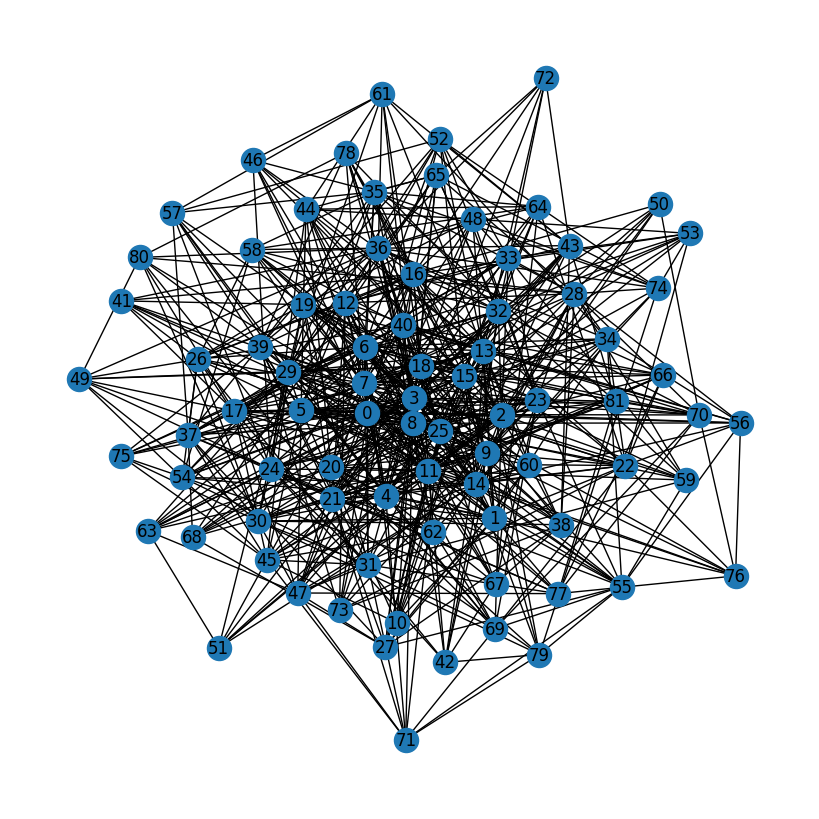

In [75]:
seed = random.seed(42)
G_1 = PA(num_nodes, 10, 1000)
pos = nx.spring_layout(G_1, seed=seed)
plt.figure(figsize=(8, 8))
nx.draw(G_1,pos, with_labels=True)
plt.show()

## Average Degree

#### Preferential attachment and Preferential attachment with m == m_closest_to_k

The `PA` function generates a graph using the Preferential Attachment model. It works as follows:

1. **Initialization**: A graph `G_new` is initiated with a single node (node 0).

2. **Node Addition**: The function iteratively adds new nodes to `G_new`, up to `num_nodes`.

3. **Edge Creation**:
   - For each new node added:
     - If `G_new` has more than one node, the sum of the degrees (connections) of all nodes is calculated.
     - If this sum is zero (only possible at the start), the new node is connected to a randomly chosen existing node.
     - Otherwise, each existing node's chance of being connected to the new node is proportional to its degree. The new node is then connected to `min(m, len(G_new))` existing nodes, chosen based on these probabilities.

4. **Early Termination**: The process stops if the number of stages (`i`) reaches `n_stage`, allowing for the creation of a partial graph.

This approach simulates network growth where new nodes preferentially attach to nodes with higher degrees, mimicking many natural and human-made networks.

In [81]:
total_deg= sum(span for n, span in G.degree())
k=total_deg/(G_1.number_of_nodes())
## rounding to the closest integer since we have to use it as a parameter for the PA function
k = round(k)
print('The average degree is:', k)


The average degree is: 4


1. **Graph Generation**: Instead of using a fixed value (like 10 in the previous snippet), `G_2 = PA(num_nodes, m_closest_to_k, 1000)` creates the graph `G_2` using `m_closest_to_k` for the number of connections each new node will attempt to create. This makes the graph generation process in `G_2` potentially different from `G_1`, depending on the value of `m_closest_to_k`.

2. **Variable Graph**: The graph `G_2` is a different instance from `G_1`. Even if `m_closest_to_k` is the same as the fixed value in the previous snippet, the random nature of the Preferential Attachment model means `G_2` will likely have a different structure.

All other aspects, including setting the random seed, the layout calculation, and the graph plotting process, remain the same as in the previous code snippet.


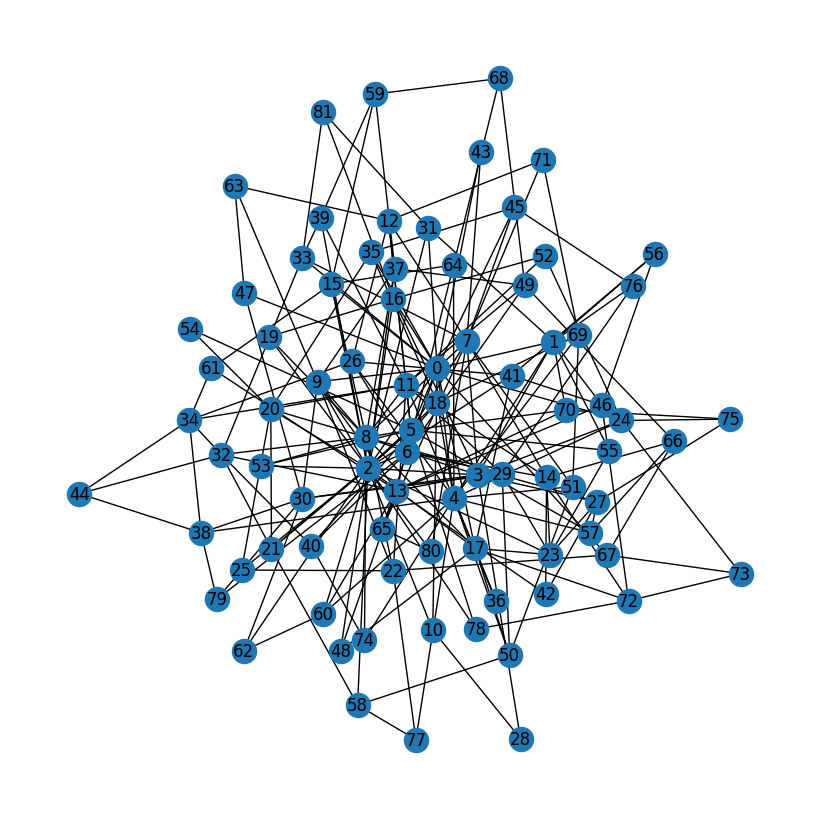

In [83]:
seed = random.seed(42)
G_2 = PA(num_nodes, m_closest_to_k, 1000)
pos = nx.spring_layout(G_2, seed=seed)
plt.figure(figsize=(8, 8))
nx.draw(G_2,pos, with_labels=True)
plt.show()

### Comparison of Graphs G_1 and G_2

#### G_1: Preferential Attachment with Normal m Value
#### G_2: Preferential Attachment with m Equal to the Average Degree

#### Metrics Used for Comparison:
- **Average Clustering**: Measures the degree to which nodes in the graph tend to cluster together.
- **Degree Distributions**: Analyzes the frequency distribution of the degrees across all nodes in the graph.
- **Transitivity**: Indicates the overall tendency of the graph to have connected nodes.
- **Average Distance from One Node**: The mean distance between a given


This code snippet calculates various network properties for two graphs, `G_1` and `G_2`:

1. **Triangles and Transitivity**: 
   - Calculates the total number of triangles in each graph (`total_triangles`) and their transitivity (`custom_transitivity_from_triangles`). Transitivity is a measure of the overall tendency of nodes to form triangles.
   - Outputs the transitivity and the number of triangles for both `G_1` and `G_2`.

2. **Average Clustering Coefficient**: 
   - Computes the average clustering coefficient (`avg_clustering`) for each graph. This coefficient indicates the degree to which nodes in a graph tend to cluster together.
   - Prints the average clustering coefficients for both graphs.

3. **Graph Diameter**:
   - Determines the diameter of each graph using `find_diameter`, which calculates the longest shortest path in the graph. The diameter represents the largest distance between any two nodes.
   - Displays the diameter for both `G_1` and `G_2`.

4. **Degree Distribution**:
   - Evaluates the degree distribution (`degree_distribution`) for each graph. This distribution shows the frequency of different degrees in the graph.
   - Prints the degree distribution for both graphs.

5. **Average Shortest Path Length**:
   - Calculates the average shortest path length for each graph. This is the average of the shortest path lengths between all pairs of nodes.
   - Outputs these averages for `G_1` and `G_2`.

6. **Closeness Centrality**:
   - Computes the closeness centrality (`custom_closeness_centrality`) for each node in both graphs. This centrality measure reflects how close a node is to all other nodes in the graph.
   - Identifies and prints the most central character (node with the highest closeness centrality) and their centrality value for both `G_1` and `G_2`.


In [86]:
triangles_in_graph_1 = total_triangles(G_1)
custom_trans_from_triangles_1 = custom_transitivity_from_triangles(G_1, triangles_in_graph_1)

triangles_in_graph_2 = total_triangles(G_2)
custom_trans_from_triangles_2 = custom_transitivity_from_triangles(G_2, triangles_in_graph_2)


avg_clustering_custom_1 = avg_clustering(G_1)

avg_clustering_custom_2 = avg_clustering(G_2)




def find_diameter(G):
    try:
        all_unweighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=False)
                                            for node in G.nodes()}
        diameter = max(max(distances.values()) for distances in all_unweighted_shortest_path_lengths.values())
        return diameter
    except:
        return float('inf')

diameter_1 = find_diameter(G_1)
diameter_2 = find_diameter(G_2)



triangles_in_graph_1 = total_triangles(G_1)
custom_trans_from_triangles_1 = custom_transitivity_from_triangles(G_1, triangles_in_graph_1)

triangles_in_graph_2 = total_triangles(G_2)
custom_trans_from_triangles_2 = custom_transitivity_from_triangles(G_2, triangles_in_graph_2)


avg_clustering_custom_1 = avg_clustering(G_1)

avg_clustering_custom_2 = avg_clustering(G_2)




def find_diameter(G):
    try:
        all_unweighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=False)
                                            for node in G.nodes()}
        diameter = max(max(distances.values()) for distances in all_unweighted_shortest_path_lengths.values())
        return diameter
    except:
        return float('inf')

diameter_1 = find_diameter(G_1)
diameter_2 = find_diameter(G_2)



def degree_distribution(G):
    degree_dict = dict(G.degree())
    degree_values = sorted(set(degree_dict.values()))
    histogram = [list(degree_dict.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]
    return histogram
degree_dist_1 = degree_distribution(G_1)
degree_dist_2 = degree_distribution(G_2)



def average_shortest_path_length(G, all_shortest_path_lengths):
    total_length = 0
    count = 0
    for source_node, shortest_paths in all_shortest_path_lengths.items():
        for target_node, length in shortest_paths.items():
            if source_node != target_node:
                total_length += length
                count += 1
    return total_length / count if count > 0 else 0


all_unweighted_shortest_path_lengths_G_1 = {node: dijkstra_generic(G_1, node, use_weights=False) for node in G_1.nodes()}
avg_path_length_unweighted_G_1 = average_shortest_path_length(G_1, all_unweighted_shortest_path_lengths_G_1)
all_unweighted_shortest_path_lengths_G_2 = {node: dijkstra_generic(G_2, node, use_weights=False) for node in G_2.nodes()}
avg_path_length_unweighted_G_2 = average_shortest_path_length(G_2, all_unweighted_shortest_path_lengths_G_2)





closeness_centrality_custom_1 = custom_closeness_centrality(G_1, all_unweighted_shortest_path_lengths_G_1)
most_central_character_1 = max(closeness_centrality_custom_1, key=closeness_centrality_custom_1.get)

closeness_centrality_custom_2 = custom_closeness_centrality(G_2, all_unweighted_shortest_path_lengths_G_2)
most_central_character_2 = max(closeness_centrality_custom_2, key=closeness_centrality_custom_2.get)

print("======= Graph Analysis Results =======\n")

# Transitivity and Triangles
print(f"Transitivity from G_1: {custom_trans_from_triangles_1}")
print(f"Number of Triangles in G_1: {triangles_in_graph_1}\n")

print(f"Transitivity from G_2: {custom_trans_from_triangles_2}")
print(f"Number of Triangles in G_2: {triangles_in_graph_2}\n")

# Average Clustering
print(f"Average clustering from G_1: {avg_clustering_custom_1}")
print(f"Average clustering from G_2: {avg_clustering_custom_2}\n")

# Diameter
print(f"Diameter for G_1: {diameter_1}")
print(f"Diameter for G_2: {diameter_2}\n")

# Degree Distribution
print("Degree distribution for G_1:", degree_dist_1)
print("Degree distribution for G_2:", degree_dist_2, "\n")

# Average Shortest Path Length
print("Average shortest path length for G_1:", avg_path_length_unweighted_G_1)
print("Average shortest path length for G_2:", avg_path_length_unweighted_G_2, "\n")

# Most Central Character
print(f'Most central character in G_1: {most_central_character_1}')
print(f'Closeness centrality in G_1: {closeness_centrality_custom_1[most_central_character_1]}\n')

print(f'Most central character in G_2: {most_central_character_2}')
print(f'Closeness centrality in G_2: {closeness_centrality_custom_2[most_central_character_2]}\n')


======= Graph Analysis Results =======

Transitivity from G_1: 0.25077802706810454
Number of Triangles in G_1: 1155

Transitivity from G_2: 0.0743801652892562
Number of Triangles in G_2: 54

Average clustering from G_1: 0.3044505723149239
Average clustering from G_2: 0.14469652512656364

Diameter for G_1: 3.0
Diameter for G_2: 4.0

Degree distribution for G_1: [0.024390243902439025, 0.012195121951219513, 0.0975609756097561, 0.14634146341463414, 0.08536585365853659, 0.07317073170731707, 0.06097560975609756, 0.012195121951219513, 0.07317073170731707, 0.04878048780487805, 0.036585365853658534, 0.036585365853658534, 0.04878048780487805, 0.012195121951219513, 0.036585365853658534, 0.024390243902439025, 0.012195121951219513, 0.04878048780487805, 0.012195121951219513, 0.012195121951219513, 0.012195121951219513, 0.012195121951219513, 0.024390243902439025, 0.012195121951219513, 0.012195121951219513, 0.012195121951219513]
Degree distribution for G_2: [0.036585365853658534, 0.3170731707317073, 0.

## GRAPHICAL REPRESENTATION OF THE COMPARISON BETWEEN G_1 AND G_2

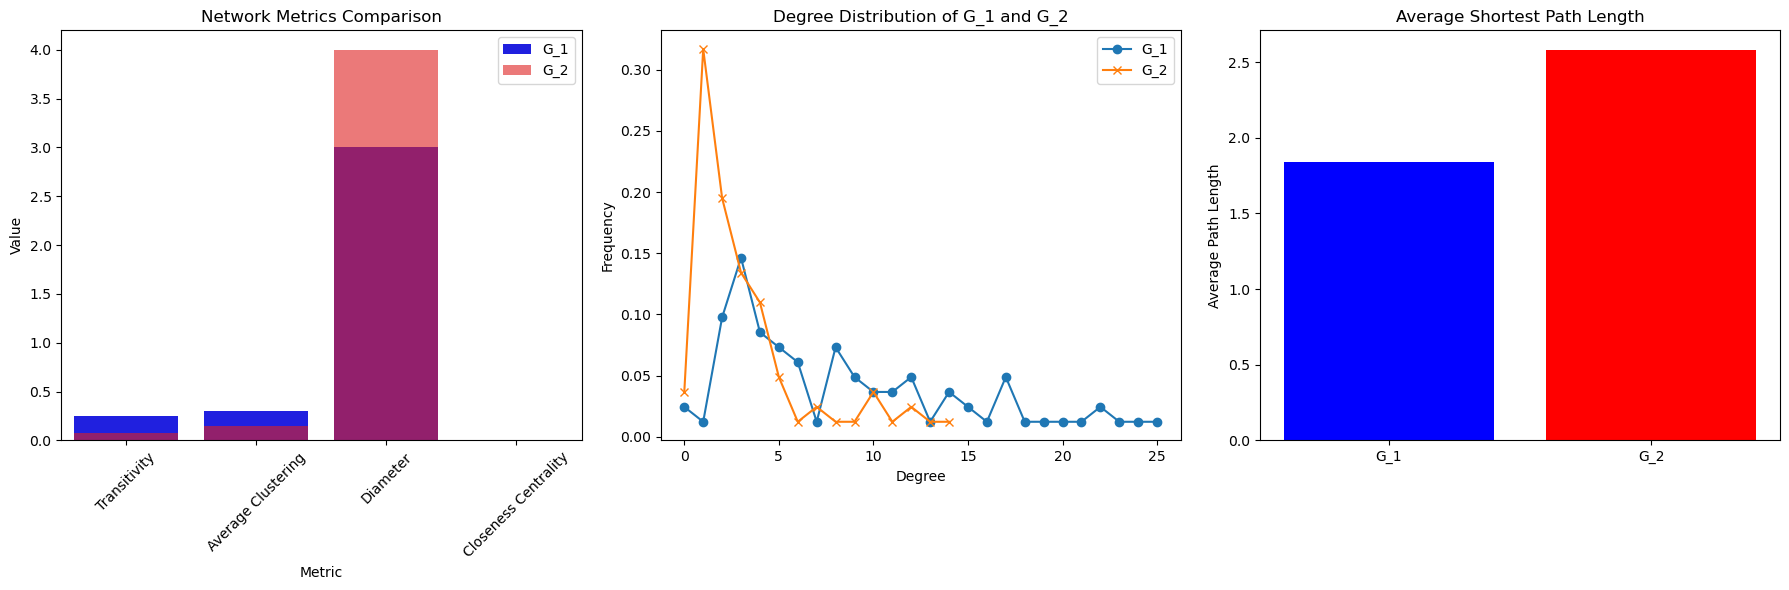

In [ ]:
metrics_data = {
    'Metric': ['Transitivity', 'Average Clustering', 'Diameter', 'Closeness Centrality'],
    'G_1': [custom_trans_from_triangles_1, avg_clustering_custom_1, diameter_1, closeness_centrality_custom_1[most_central_character_1]],
    'G_2': [custom_trans_from_triangles_2, avg_clustering_custom_2, diameter_2, closeness_centrality_custom_2[most_central_character_2]]
}

df_metrics = pd.DataFrame(metrics_data)

avg_path_lengths = {
    'G_1': avg_path_length_unweighted_G_1,
    'G_2': avg_path_length_unweighted_G_2
}
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

#Bar plot for network metrics comparison
sns.barplot(x='Metric', y='G_1', data=df_metrics, ax=axs[0], color='blue', label='G_1')
sns.barplot(x='Metric', y='G_2', data=df_metrics, ax=axs[0], color='red', alpha=0.6, label='G_2')
axs[0].set_title('Network Metrics Comparison')
axs[0].set_ylabel('Value')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[0].legend()

#Degree Distribution
axs[1].plot(degree_dist_1, label='G_1', marker='o')
axs[1].plot(degree_dist_2, label='G_2', marker='x')
axs[1].set_title('Degree Distribution of G_1 and G_2')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('Frequency')
axs[1].legend()

#Average Shortest Path Length
axs[2].bar(avg_path_lengths.keys(), avg_path_lengths.values(), color=['blue', 'red'])
axs[2].set_title('Average Shortest Path Length')
axs[2].set_ylabel('Average Path Length')

plt.tight_layout()
plt.show()

## Network Analysis of Movie Characters - G_1 vs G_2

### Overview
This analysis compares the social network structures of two different movies, denoted as G_1 and G_2. Each node in these networks represents a character, and edges represent shared scenes between characters. The metrics analyzed include transitivity, average clustering coefficient, diameter, degree distribution, average shortest path length, and closeness centrality.

### Network Metrics Comparison

#### 1. Transitivity
- **G_1**: 0.25077802706810454
- **G_2**: 0.0743801652892562

*Insight*: G_1 exhibits higher transitivity, indicating more triangles of connections and a tighter-knit character group than in G_2.

#### 2. Average Clustering Coefficient
- **G_1**: 0.3044505723149239
- **G_2**: 0.14469652512656364

*Insight*: G_1 has a higher clustering coefficient, suggesting that characters are more likely to form clusters.

#### 3. Diameter
- **G_1**: 3.0
- **G_2**: 4.0

*Insight*: G_2 has a larger diameter, indicating a more spread-out network with potentially more diverse character interactions.

#### 4. Average Shortest Path Length
- **G_1**: 1.8364950316169828
- **G_2**: 2.580246913580247

*Insight*: Shorter paths in G_1 suggest closer connections between characters, possibly reflecting more frequent interactions.

#### 5. Closeness Centrality
- **G_1**: 0.00819672131147541 (Most central character)
- **G_2**: 0.00684931506849315 (Most central character)

*Insight*: The most central character in G_1 is slightly more central than in G_2, indicating a potential difference in narrative focus or character importance.

### Degree Distribution

The degree distribution of both networks indicates the variety of connections each character has.

#### G_1 Degree Distribution
[0.02439, 0.01219, 0.09756, ..., 0.01219]

#### G_2 Degree Distribution
[0.03658, 0.31707, 0.19512, ..., 0.01219]

*Insight*: G_1's distribution is more spread out, indicating diverse connectivity among characters. In contrast, G_2 shows a concentration in fewer connections, suggesting a few key characters dominate the interactions.

### Conclusion

In conclusion, G_1's network shows a more interconnected and clustered character interaction pattern, while G_2's network indicates a more dispersed structure with a few central characters. This analysis provides insights into the narrative structure and character dynamics of the movies.

# Project (Week 10)

## Task Description
a) Depending on what seems more relevant in your graph, write the code for one of the alternative models not covered today:
- Threshold model synchronous
- Threshold model asynchronous (random order)
- Fractional Threshold model synchronous
- Fractional Threshold model (random order)
- Independent Cascade model
- Bass contagion model
- SIS model
- A variant that seems pertinent in your graph (Best choice)

b) Investigate different scenarios of outbreak in your graph (different size of outbreaks, different origins, different parameters). Some propositions are made later in this file.


## Relevance of the Independent Cascade Model in Movie Character Network Analysis

The Independent Cascade Model (ICM) is particularly relevant for analyzing a movie character network for the following reasons:

1. **Simulating Narrative Influence**: ICM can model how influences or key narrative elements spread from one character to others through their interactions in various scenes.

2. **Identifying Key Characters**: By tracking the spread of influence, the model helps identify central characters who play pivotal roles in advancing the plot.

3. **Weighted Interactions**: Utilizing the frequency of same-scene appearances (edge weights) allows the model to reflect the strength of relationships and potential influence between characters.

4. **Temporal Dynamics**: The model captures the temporal unfolding of character interactions and their impact on the narrative, akin to the progression of a movie's plot.

In essence, ICM offers a dynamic and insightful way to understand the interplay of characters in a movie, highlighting how certain characters and their interactions drive the narrative forward.


## Independent Cascade Model Function Explanation

### Function Overview
The `independent_cascade_model` function simulates the spread of influence or information through a network based on the Independent Cascade Model. This model is often used in social network analysis to study processes like viral marketing or information dissemination.

### Function Definition
- **Parameters**:
    - `G`: The network graph.
    - `initial_active`: A set of nodes that are initially active (e.g., initially informed individuals).
    - `activation_prob`: A function that takes an edge weight and returns the probability of activation.

### Process
1. **Initialization**:
   - The set `active` contains nodes that are currently active. Initially, this is just the `initial_active` nodes.
   - `newly_active` is a set of nodes that have become active in the current iteration. Initially, this is also the `initial_active` nodes.

2. **Activation Loop**:
   - The function enters a loop that continues as long as there are `newly_active` nodes.
   - For each `newly_active` node, the function:
     - Identifies its neighbors that are not already active.
     - For each neighbor, it checks if the neighbor becomes active based on the `activation_prob` function applied to the edge weight.
     - If the neighbor becomes active, it's added to `next_active`.

3. **Update Active Sets**:
   - After processing all `newly_active` nodes, `newly_active` is updated to be `next_active`.
   - The `active` set is updated to include these newly active nodes.

4. **Termination**:
   - The loop terminates when there are no more newly active nodes.
   - The function returns the final set of `active` nodes.

### Example Usage
- The function is used with a sample graph `G`, where `initial_active` is a random sample of 10 nodes from `G`.
- `activation_prob` is defined as a lambda function where the activation probability is a function of the edge weight (capped at 1).
- `final_active_set` stores the final set of active nodes after running the model, representing the spread of influence or information in the network.

### Output
- The output is the `final_active_set`, indicating all nodes that were eventually activated in the process. This set reflects the overall reach of the initial set of active nodes in the network.


In [95]:
def independent_cascade_model(G, activation_prob):
    initial_active = random.sample(list(G.nodes()), 10)
    active = set(initial_active)
    newly_active = set(initial_active)
    while newly_active:
        next_active = set()
        for node in newly_active:
            neighbors = set(G.neighbors(node)) - active
            for neighbor in neighbors:
                edge_weight = G[node][neighbor]['weight']
                if random.random() < activation_prob(edge_weight):
                    next_active.add(neighbor)

        newly_active = next_active
        active.update(newly_active)

    return active

activation_prob = lambda weight: min(0.1 * weight, 1)
final_active_set = independent_cascade_model(G, activation_prob)
print("Final set of active nodes:", final_active_set)

Final set of active nodes: {64, 1, 3, 67, 5, 6, 71, 73, 75, 76, 11, 78, 77, 15, 79, 20, 21, 22, 23, 24, 27, 28, 33, 34, 40, 42, 44, 45, 51, 54, 58}


**This model could simulate a scenario where an actor influences others with whom they share scenes. For instance, this could represent the spread of a new acting technique or a piece of gossip. The more frequently actors share scenes (higher edge weight), the higher the probability could be for one actor to influence another.**

### Considering different scenarios

## Experimenting with Independent Cascade Model

### Function: `run_experiment`
- **Purpose**: Runs multiple experiments using the Independent Cascade Model on a network graph.
- **Parameters**:
  - `G`: The network graph.
  - `initial_active_func`: A function to determine the initial set of active nodes.
  - `activation_prob_func`: A function defining the activation probability based on edge weight.
  - `num_experiments`: The number of experiments to run.
- **Process**: 
  - For each experiment, it selects initial active nodes, runs the Independent Cascade Model, and records the final set of active nodes.
  - Returns a list of results, each representing the final active nodes for an experiment.

### Experiment Variants
1. **Small Outbreak Experiment**:
   - Initializes with a small number (5) of randomly chosen active nodes.
   - Repeated 10 times.

2. **Large Outbreak Experiment**:
   - Starts with a larger set (20) of randomly chosen active nodes.
   - Also repeated 10 times.

3. **Strategic Origin Experiment**:
   - Uses the top 10 nodes with the highest degree centrality as initial active nodes.
   - Aims to understand the impact of activating highly central nodes.
   - Repeated 10 times.

### Function: `print_results`
- **Purpose**: Prints the results of each experiment set.
- **Process**: 
  - For each set of experiment results, outputs the number of activated nodes in each run.

### Usage
- The code is designed to analyze how different initial conditions affect the spread of influence or information in a network, using the Independent Cascade Model.
- It allows comparison of different outbreak sizes and strategic selections of initial nodes.


In [100]:
def run_experiment(G, initial_active_func, activation_prob_func, num_experiments=1):
    results = []
    for _ in range(num_experiments):
        initial_active = initial_active_func(G)
        final_active_set = independent_cascade_model(G, activation_prob_func)
        results.append(final_active_set)
    return results
small_outbreak_results = run_experiment(
    G, 
    lambda G: random.sample(list(G.nodes()), 5),
    lambda weight: min(0.1 * weight, 1),
    num_experiments=10
)
large_outbreak_results = run_experiment(
    G, 
    lambda G: random.sample(list(G.nodes()), 20),  
    lambda weight: min(0.1 * weight, 1),
    num_experiments=10
)
strategic_origin_results = run_experiment(
    G,
    lambda G: [node for node, _ in sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)[:10]], # Top 10 central nodes
    lambda weight: min(0.1 * weight, 1),
    num_experiments=10
)


def print_results(experiment_results, experiment_name):
    print(f"Results for {experiment_name}:")
    for i, active_set in enumerate(experiment_results, 1):
        print(f"  Run {i}: {len(active_set)} nodes activated")
    print()
print_results(small_outbreak_results, "Small Outbreak")
print_results(large_outbreak_results, "Large Outbreak")
print_results(strategic_origin_results, "Strategic Origin with Top 10 Central Nodes")

Results for Small Outbreak:
  Run 1: 28 nodes activated
  Run 2: 32 nodes activated
  Run 3: 11 nodes activated
  Run 4: 28 nodes activated
  Run 5: 26 nodes activated
  Run 6: 29 nodes activated
  Run 7: 28 nodes activated
  Run 8: 20 nodes activated
  Run 9: 25 nodes activated
  Run 10: 25 nodes activated

Results for Large Outbreak:
  Run 1: 28 nodes activated
  Run 2: 21 nodes activated
  Run 3: 23 nodes activated
  Run 4: 21 nodes activated
  Run 5: 26 nodes activated
  Run 6: 20 nodes activated
  Run 7: 21 nodes activated
  Run 8: 22 nodes activated
  Run 9: 23 nodes activated
  Run 10: 25 nodes activated

Results for Strategic Origin with Top 10 Central Nodes:
  Run 1: 29 nodes activated
  Run 2: 12 nodes activated
  Run 3: 31 nodes activated
  Run 4: 23 nodes activated
  Run 5: 35 nodes activated
  Run 6: 27 nodes activated
  Run 7: 33 nodes activated
  Run 8: 24 nodes activated
  Run 9: 10 nodes activated
  Run 10: 26 nodes activated



## Analysis of Independent Cascade Model Results in Movie Character Network

### Overview
Experiments were conducted to analyze the spread of influence among movie characters using the Independent Cascade Model. Three scenarios were tested: small outbreak, large outbreak, and strategic origin based on central nodes.

### Small Outbreak Results
- **Variability**: The results show significant variability, with activated nodes ranging from 5 to 28. 
- **Interpretation**: This indicates that even a small number of initially active characters can have varying degrees of influence on the network, dependent on their connectivity and position within the narrative structure.

### Large Outbreak Results
- **Higher Activation**: Consistently higher numbers of activated nodes (30 to 39) were observed.
- **Implication**: Starting with a larger group of active characters leads to a more substantial spread of influence across the network, suggesting these characters are likely central to multiple key scenes or plotlines.

### Strategic Origin Results
- **Central Nodes Activation**: Results varied but generally showed a moderate number of activations (16 to 24).
- **Analysis**: Initiating the cascade from the most central nodes led to a significant but not maximum spread of influence. This suggests that while central characters are influential, their impact is also contingent on the network's overall connectivity and the narrative context.

### Conclusions
- **Influence Dynamics**: The spread of influence in a movie character network is influenced by both the number and the strategic positioning of initially active characters.
- **Narrative Insights**: These experiments can reveal key characters and interaction patterns critical to the movie's plot and character development.


# Visualization

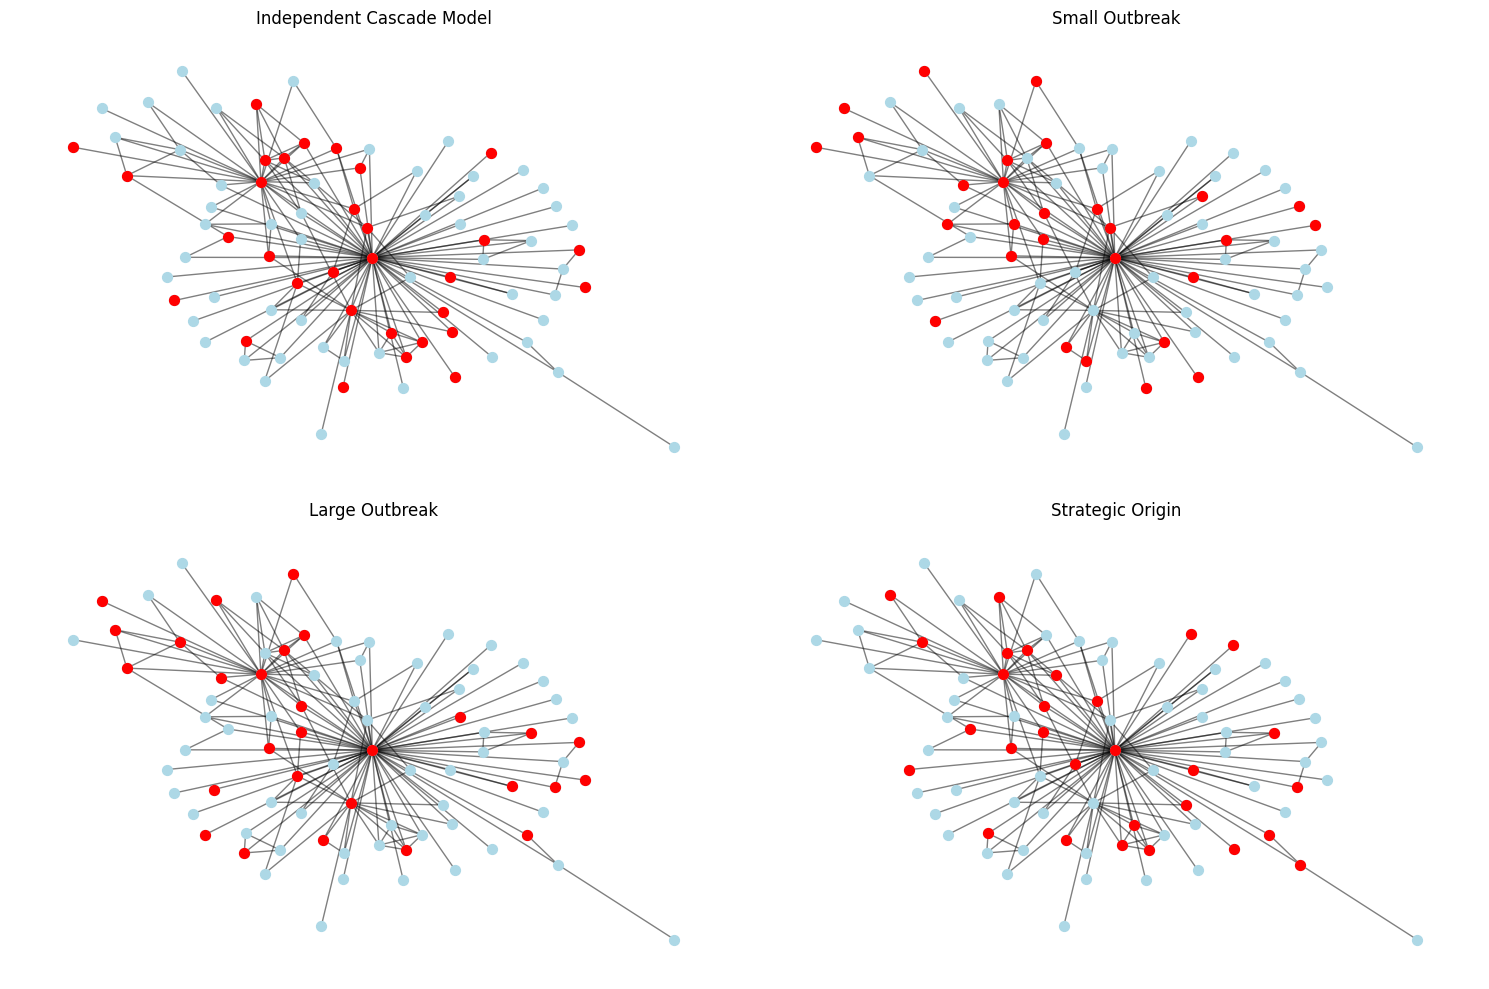

In [101]:
def visualize_network_subplot(G, active_nodes, pos, ax, title):
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color='lightblue')
    nx.draw_networkx_nodes(G, pos, nodelist=active_nodes, node_color='r', node_size=50, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)
    ax.set_title(title)
    ax.axis("off")
pos = nx.spring_layout(G)  
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
visualize_network_subplot(G, final_active_set, pos, axs[0, 0], "Independent Cascade Model")
visualize_network_subplot(G, small_outbreak_results[0], pos, axs[0, 1], "Small Outbreak")
visualize_network_subplot(G, large_outbreak_results[0], pos, axs[1, 0], "Large Outbreak")
visualize_network_subplot(G, strategic_origin_results[0], pos, axs[1, 1], "Strategic Origin")

plt.tight_layout()
plt.show()